In [1]:
import time
import warnings

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from lime.lime_tabular import LimeTabularExplainer
from pandas.core.frame import DataFrame
from scipy.linalg import LinAlgWarning
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
class StringDataTransformer(BaseEstimator, TransformerMixin):
    STRING_COLUMNS_NAMES = ["BuildingType", "PrimaryPropertyType", "Neighborhood"]

    def __init__(self, consider_string_values=False, encoding_mode="None", keep_energy_star_score=False):
        self.consider_string_values = consider_string_values
        self.encoding_mode = encoding_mode
        self.keep_energy_star_score = keep_energy_star_score
        self.te = TargetEncoder(target_type="continuous", )
        self.ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    def fit(self, x, y=None):
        x = DataFrame(x, columns=x.columns)

        if self.encoding_mode == "OneHotEncoding":
            self.ohe.fit(x[self.STRING_COLUMNS_NAMES])

        if self.encoding_mode == "TargetEncoding":
            self.te.fit(x[self.STRING_COLUMNS_NAMES], y)

        return self

    def transform_data(self, x, transformer):
        transformed_x = transformer.transform(x[self.STRING_COLUMNS_NAMES])
        transformed_x_df = DataFrame(transformed_x, columns=transformer.get_feature_names_out(self.STRING_COLUMNS_NAMES))
        transformed_x_df.index = x.index

        encoded_df = pd.concat([x, transformed_x_df], axis=1)
        x = encoded_df.drop(self.STRING_COLUMNS_NAMES, axis=1)

        return x

    def transform(self, x, y=None):
        if not self.consider_string_values:
            return x.drop(columns=self.STRING_COLUMNS_NAMES, axis=1)

        if self.encoding_mode == "OneHotEncoding":
            x = self.transform_data(x, self.ohe)

        if self.encoding_mode == "TargetEncoding":
            x = self.transform_data(x, self.te)

        return x

    def get_params(self, deep=True):
        return {
            "consider_string_values": self.consider_string_values,
            "encoding_mode": self.encoding_mode
        }

    def set_params(self, **parameters):
        self.consider_string_values = parameters["consider_string_values"]
        self.encoding_mode = parameters["encoding_mode"]
        return self

In [4]:
class NumericDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_energy_proportions_data=False, data_transformation_mode="None", use_log_values=False):
        self.add_energy_proportions_data = add_energy_proportions_data
        self.data_transformation_mode = data_transformation_mode
        self.use_log_values = use_log_values
        self.min_max_scaler = MinMaxScaler()
        self.standard_scaler = StandardScaler()

    def fit(self, x, y=None):
        if self.data_transformation_mode == "normalization":
            self.min_max_scaler.fit(x)

        elif self.data_transformation_mode == "standardization":
            self.standard_scaler.fit(x)

        return self

    def transform(self, x, y=None):
        columns = x.columns
        if self.data_transformation_mode == "normalization":
            x = self.min_max_scaler.transform(x)

        elif self.data_transformation_mode == "standardization":
            x = self.standard_scaler.transform(x)

        x = DataFrame(x, columns=columns)

        if self.use_log_values:
            for column in columns:
                x[column] = np.log1p(x[column]) \
                    if np.issubdtype(x[column].dtype, np.number) and x[column].min() > 0 else x[column]

        if not self.add_energy_proportions_data:
            x.drop(columns=["SteamProportion", "NaturalGasProportion"], axis=1, inplace=True)

        return x

    def get_params(self, deep=True):
        return {
            "add_energy_proportions_data": self.add_energy_proportions_data,
            "data_transformation_mode": self.data_transformation_mode,
            "use_log_values": self.use_log_values
        }

    def set_params(self, **parameters):
        self.add_energy_proportions_data = parameters["add_energy_proportions_data"]
        self.data_transformation_mode = parameters["data_transformation_mode"]
        self.use_log_values = parameters["use_log_values"]
        return self

In [5]:
DATA_FILEPATH = "resources/2016_Building_Energy_Benchmarking.csv"

In [6]:
TARGET_COLUMN = "GHGEmissionsIntensity"
# TARGET_COLUMN = "SiteEUIWN(kBtu/sf)"
ENERGY_STAR_SCORE_COLUMN = "ENERGYSTARScore"

In [7]:
CONSIDERED_COLUMNS = ["BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode", "CouncilDistrictCode",
                      "ComplianceStatus", "Latitude", "Longitude", "YearBuilt", "NumberofBuildings", "NumberofFloors",
                      "PropertyGFABuilding(s)", "SteamUse(kBtu)", "NaturalGas(kBtu)", "SiteEnergyUseWN(kBtu)",
                      TARGET_COLUMN]
STRING_COLUMNS_NAMES = ["BuildingType", "PrimaryPropertyType", "Neighborhood"]

In [8]:
def display_plot(plot, filename: str, prefix: str) -> None:
    plt.show()
    plt.close()

In [9]:
def remove_duplicates(dataframe: DataFrame) -> None:
    initial_count = len(dataframe)
    pd.DataFrame.drop_duplicates(dataframe, subset=['PropertyName'], inplace=True)
    duplicates_number = initial_count - len(dataframe)
    print(f"{duplicates_number} duplicates were removed based on the PropertyName.\n")

In [10]:
def load_and_filter_data(with_energy_star_score=False) -> DataFrame:
    df: DataFrame = pd.read_csv(DATA_FILEPATH, header=0, sep=",")
    remove_duplicates(df)
    
    if with_energy_star_score:
        return df[CONSIDERED_COLUMNS + [ENERGY_STAR_SCORE_COLUMN]]
    else:
        return df[CONSIDERED_COLUMNS]

In [11]:
def clean_dataset(df: DataFrame) -> DataFrame:
    df = df.drop(df[df['NumberofBuildings'] == 0].index)
    df = df.drop(df[(df['NumberofFloors'] == 0) | (df['NumberofFloors'] > 80)].index)
    df = df.drop(df[df["SiteEnergyUseWN(kBtu)"] == 0].index)
    df = df.drop(df[df[TARGET_COLUMN] == 0].index)
    df = df.drop(df[df["ComplianceStatus"] != "Compliant"].index)
    df = df.drop(columns=["ComplianceStatus"], axis=1)
    df['Neighborhood'] = df['Neighborhood'].str.upper()
    return df.dropna()

In [12]:
def clean_non_habitation_buildings(df):
    initial_size = len(df)
    non_residential_buildings_df = df[~df.BuildingType.str.contains("Multifamily")]
    print(f"Removing {initial_size - len(non_residential_buildings_df)} non-residential buildings")
    return non_residential_buildings_df

In [13]:
def prepare_data(df: DataFrame) -> DataFrame:
    df = clean_dataset(df)
    df = add_energy_proportions_columns(df)
    df = clean_non_habitation_buildings(df)
    return df

In [14]:
def add_energy_proportions_columns(df):
    steam_column = df.apply(lambda row: add_energy_proportion_column(row, 'SteamUse'), axis=1)
    df = df.assign(**{'SteamProportion': steam_column.values})
    
    natural_gas_column = df.apply(lambda row: add_energy_proportion_column(row, 'NaturalGas'), axis=1)
    df = df.assign(**{'NaturalGasProportion': natural_gas_column.values})
    
    if TARGET_COLUMN != "SiteEnergyUseWN(kBtu)":
        df.drop(columns=["SiteEnergyUseWN(kBtu)"], axis=1, inplace=True)
        
    return df

In [15]:
def create_feature_importance_plots(model, keys, model_name):
    features = []
    
    if hasattr(model, 'feature_importances_'):
        sns.set_theme(rc={'figure.figsize': (17, 12)})
        feature_importances = model.feature_importances_
        for result in sorted(zip(feature_importances, keys), reverse=True):
            score = result[0]
            if score > 0.01:
                features.append({"name": result[1], "score": score})
                
    elif hasattr(model, 'coef_'):
        sns.set_theme(rc={'figure.figsize': (30, 20)})
        importance = model.coef_
        for i, v in enumerate(importance):
            if v != 0:
                features.append({"name": keys[i], "score": v})
    else:
        print("No feature importance could be determined for the current model\n")
        return

    barplot = sns.barplot(DataFrame(features), x="score", y="name", hue="name", legend=False)
    barplot.set(xlabel=None)
    barplot.set(ylabel=None)
    display_plot(barplot, f"feature_importance_{model_name}", "feature_importance")

In [16]:
def add_energy_proportion_column(row, energy_name):
    try:
        if row[f'{energy_name}(kBtu)'] < 1:
            return 0.0
        return round(float(row[f'{energy_name}(kBtu)'] / row[f'SiteEnergyUseWN(kBtu)']), 2)
    except ValueError:
        return 0.0

def get_accuracy_of_predictions(grid_search_cv, x_test, y_test, x_train, y_train):<br>
    # Root Mean Squared Error: average difference between values<br>
    train_score = grid_search_cv.score(x_train, y_train)<br>
    test_score = grid_search_cv.score(x_test, y_test)<br>
    print(f"train_score:{train_score}, test_score:{test_score}")<br>
    rmse_train_accuracy = np.sqrt(-1 * train_score)<br>
    rmse_test_accuracy = np.sqrt(-1 * test_score)<br>
<br>
    # Another way to verify the prediction of a set, typically used if you have a third validation set<br>
    final_model = grid_search_cv.best_estimator_<br>
    final_predictions = final_model.predict(x_test)<br>
    final_mse = mean_squared_error(y_test, final_predictions)<br>
    final_rmse2 = np.sqrt(final_mse)<br>
    print(f"RMSE2:{final_rmse2}")<br>
<br>
    return rmse_train_accuracy, rmse_test_accuracy

In [17]:
def get_models_and_their_hyperparameters():
    data_transformers_parameters_grid = {
        'string-data-transformer__consider_string_values': [False, True],
        'string-data-transformer__encoding_mode': ["OneHotEncoding", "TargetEncoding"],
        'numeric-data-transformer__add_energy_proportions_data': [True, False],
        'numeric-data-transformer__data_transformation_mode': ["None", "normalization", "standardization"],
        'numeric-data-transformer__use_log_values': [False, True]
    }
    
    return [
        {
            **data_transformers_parameters_grid,

            # The Least Absolute Shrinkage and Selection Operator is abbreviated as “LASSO.” Lasso regression is a type
            # of regularisation. It is preferred over regression methods for more precise prediction. This model makes
            # use of shrinkage which is the process by which data values are shrunk towards a central point known as
            # the mean. L1 regularisation is used in Lasso Regression. It is used when there are many features because
            # it performs feature selection automatically. The main purpose of Lasso Regression is to find the
            # coefficients that minimize the error sum of squares by applying a penalty to these coefficients.
            'model': [Lasso()],
            # 'model__alpha': [0.2],
            'model__alpha': np.arange(0.01, 1.0, 0.01),
        },
        {
            **data_transformers_parameters_grid,

            # Similar to the LASSO regression, ridge regression puts a similar constraint on the coefficients by
            # introducing a penalty factor. However, while lasso regression takes the magnitude of the coefficients,
            # ridge regression takes the square.
            'model': [Ridge()],
            'model__alpha': np.arange(1, 100.0, 1),
        },
        {
            **data_transformers_parameters_grid,

            # The elastic net is a regularized regression method that linearly combines the L1 and L2 penalties
            # of the lasso and ridge methods.
            'model': [ElasticNet()],
            'model__alpha': [1e-2, 1e-1, 1.0, 10.0],
            'model__l1_ratio': np.arange(0.1, 1, 0.1)
        },
        {
            **data_transformers_parameters_grid,

            # SVM works by finding a hyperplane in a high-dimensional space that best separates data into different
            # classes. It aims to maximize the margin (the distance between the hyperplane and the nearest data points
            # of each class) while minimizing classification errors.
            # SVR extends Support Vector Machines (SVM) into regression problems, allowing for the prediction of
            # continuous outcomes rather than classifying data into discrete categories as with a classifier.
            'model': [SVR(cache_size=500)],
            'model__C': [0.1, 1, 10, 100, 1000], 'model__gamma': [0.001, 0.0001],
            'model__epsilon': [0.001, 0.01, 0.1, 1]
        },
        {
            **data_transformers_parameters_grid,

            # The decision tree uses a tree structure. Starting from tree root, branching according to the conditions
            # and heading toward the leaves, the goal leaf is the prediction result. This decision tree has the
            # disadvantage of overfitting test data if the hierarchy is too deep. As a means to prevent this
            # overfitting, the idea of the ensemble method is used for decision trees. This technique uses a
            # combination of multiple decision trees rather than simply a single decision tree.
            #
            # Random forests create multiple decision trees by splitting a dataset based on random numbers.
            # It prevents overfitting by making predictions for all individual decision trees and
            # averaging the regression results.
            'model': [RandomForestRegressor(n_estimators=300)],
            'model__max_depth': range(2, 8), 'model__max_features': range(2, 10)
        },
        {
            **data_transformers_parameters_grid,

            # Gradient boosting, on the other hand, is a technique for repeatedly adding decision trees so that the
            # next decision tree corrects the previous decision tree error. Compared to Random forest, the results are
            # more sensitive to parameter settings during training. However, with the correct parameter settings,
            # you will get better test results than random forest.
            'model': [GradientBoostingRegressor(n_estimators=300)],
            'model__max_depth': range(2, 8), 'model__max_features': range(2, 11)
        },
        {
            **data_transformers_parameters_grid,

            # XGBoost ('eXtreme Gradient Boosting') and sklearn's GradientBoost are fundamentally the same as they are
            # both gradient boosting implementations. XGBoost is a lot faster than sklearn's. XGBoost is quite
            # memory-efficient and can be parallelized. # Having used both, XGBoost's speed is quite impressive and
            # its performance is superior to sklearn's GradientBoosting.
            # https://xgboost.readthedocs.io/en/stable/tutorials/model.html
            'model': [xgboost.XGBRegressor(tree_method="hist", n_estimators=300)],
            'model__max_depth': range(2, 11)
        }
    ]

In [18]:
def create_comparison_plots(results, scoring):
    results_df = pd.DataFrame(results)
    
    for score in scoring:
        results_df.sort_values(f"{score}_test_score", inplace=True)
        performance_plot = (results_df[[f"{score}_train_score", f"{score}_test_score", "model_name"]]
                            .plot(kind="bar", x="model_name", figsize=(15, 8), rot=0,
                                  title="Models Performance Sorted by Test Accuracy"))
        performance_plot.legend([f"{score} Train Accuracy", f"{score} Test Accuracy"])
        performance_plot.title.set_size(20)
        performance_plot.set(xlabel=None)
        display_plot(performance_plot, f"{score}_performance_plot", "comparison")
        
    results_df.sort_values("fit_time", inplace=True)
    cv_time_plot = (results_df[["fit_time", "model_name"]]
                    .plot(kind="bar", x="model_name", figsize=(15, 5), rot=0,
                          title="Models Gridsearch CV Fitting time (seconds)"))
    cv_time_plot.title.set_size(20)
    cv_time_plot.legend(["Gridsearch CV Time"])
    cv_time_plot.set(xlabel=None)
    display_plot(cv_time_plot, "cv_time_plot", "comparison")

In [19]:
def explain_results_using_shap(model, model_name, x_test):
    try:
        if model_name in ["RandomForestRegressor", "GradientBoostingRegressor"]:
            shap_values = shap.TreeExplainer(model).shap_values(x_test)
        else:
            explainer = shap.KernelExplainer(model.predict, shap.sample(x_test, 5))
            shap_values = explainer(x_test)
            
        shap.summary_plot(shap_values, x_test)
        # plt.savefig(f'plots/shap_results/summary_plot_{model_name}.png')
        plt.show()
        plt.close()
        
    except Exception as e:
        print(f"Shap analysis failed for model:{model_name} because:", e)

In [20]:
def explain_results_using_lime(x_train, x_test, model_name, model, feat_names):
    explainer = LimeTabularExplainer(x_train.to_numpy(), feature_names=feat_names,
                                     class_names=[TARGET_COLUMN], verbose=True, mode='regression')
    for i in range(4):
        try:
            explanation = explainer.explain_instance(x_test.to_numpy()[i], model.predict, num_features=10)
            lime_results = []
            
            for feat_index, ex in explanation.as_map()[1]:
                lime_results.append({"name": feat_names[feat_index], "score": ex})
                
            barplot = sns.barplot(DataFrame(lime_results), x="score", y="name", hue="name", legend=False)
            barplot.set(xlabel=None)
            barplot.set(ylabel=None)
            display_plot(barplot, f"lime_results_{model_name}_{i}", "lime_results")
        except Exception as e:
            print(f"Lime analysis for model:{model_name} failed because of:", e)

In [21]:
def transform_sets_to_current_best_parameters(x_train, x_test, y_train, y_test, best_parameters):
    transformed_x_train = Pipeline(steps=[
        ("string-data-transformer", StringDataTransformer(
            consider_string_values=best_parameters['string-data-transformer__consider_string_values'],
            encoding_mode=best_parameters['string-data-transformer__encoding_mode'])),
        ("numeric-data-transformer", NumericDataTransformer(
            add_energy_proportions_data=best_parameters['numeric-data-transformer__add_energy_proportions_data'],
            data_transformation_mode=best_parameters['numeric-data-transformer__data_transformation_mode']))
    ]).fit_transform(x_train, y_train)
    
    transformed_x_test = Pipeline(steps=[
        ("string-data-transformer", StringDataTransformer(
            consider_string_values=best_parameters['string-data-transformer__consider_string_values'],
            encoding_mode=best_parameters['string-data-transformer__encoding_mode'])),
        ("numeric-data-transformer", NumericDataTransformer(
            add_energy_proportions_data=best_parameters['numeric-data-transformer__add_energy_proportions_data'],
            data_transformation_mode=best_parameters['numeric-data-transformer__data_transformation_mode']))
    ]).fit_transform(x_test, y_test)
    
    return transformed_x_train, transformed_x_test

In [22]:
def add_scores_to_result(result, cv_results, scoring):
    for scorer in scoring:
        best_train_score = max(cv_results["mean_train_" + scorer])
        best_test_score = max(cv_results["mean_test_" + scorer])
        result[f"{scorer}_train_score"] = best_train_score
        result[f"{scorer}_test_score"] = best_test_score

In [23]:
def evaluate_impact_of_energy_star_score(model_parameters, model_name):
    print("\nNow using the model with the best score to evaluate the impact of the Energy Star Score.\n")
    
    dataframe: DataFrame = load_and_filter_data(with_energy_star_score=True)
    dataframe = prepare_data(dataframe)
    
    set_without_target_column_values = dataframe.drop(TARGET_COLUMN, axis=1)
    target_column_values = dataframe[TARGET_COLUMN]
    x_train, x_test, y_train, y_test = train_test_split(set_without_target_column_values, target_column_values,
                                                        test_size=0.2, random_state=42)
    results = []
    for with_energy_star_score in [False, True]:
        if not with_energy_star_score:
            x_train.drop(ENERGY_STAR_SCORE_COLUMN, axis=1, inplace=True)
        pipeline = Pipeline(steps=[
            ("string-data-transformer", StringDataTransformer()),
            ("numeric-data-transformer", NumericDataTransformer()),
            ("model", LinearRegression())
        ])
        grid_search_cv = GridSearchCV(pipeline, model_parameters, cv=KFold(10, shuffle=True), n_jobs=-1,
                                      scoring='neg_root_mean_squared_error', refit=True, return_train_score=True)
        grid_search_cv.fit(x_train, y_train)
        
        print(f"Best mean squared score:{grid_search_cv.best_score_} {'with' if with_energy_star_score else 'without'} "
              f"energy star score.")
        
        cv_results = grid_search_cv.cv_results_
        best_train_score = max(cv_results["mean_train_score"])
        best_test_score = max(cv_results["mean_test_score"])
        results.append({"description": f"{'With' if with_energy_star_score else 'Without'} Star score",
                        "train_score": best_train_score,
                        "test_score": best_test_score})
        
    results_df = DataFrame(results)
    results_df.sort_values(f"test_score", inplace=True)
    performance_plot = (results_df[["train_score", "test_score", "description"]]
                        .plot(kind="bar", x="description", figsize=(15, 8), rot=0,
                              title=f"Models Performance of {model_name} using Energy Star Score for {TARGET_COLUMN}"))
    performance_plot.legend(["Train Accuracy", "Test Accuracy"])
    performance_plot.title.set_size(20)
    performance_plot.set(xlabel=None)
    display_plot(performance_plot, f"Star_score_performance_plot", "comparison")

Starting script.

14 duplicates were removed based on the PropertyName.

The dataset has been loaded and filtered. Let's clean the data.

Dataset size before cleaning and preparation:3362
Removing 1607 non-residential buildings
Dataset size after cleaning and preparation:1453

training set size:1162, test set size:291

Evaluation started for model:Lasso
Best mean squared score:-1.4070743459311474 with params:{'model': Lasso(), 'model__alpha': 0.02, 'numeric-data-transformer__add_energy_proportions_data': True, 'numeric-data-transformer__data_transformation_mode': 'standardization', 'numeric-data-transformer__use_log_values': False, 'string-data-transformer__consider_string_values': True, 'string-data-transformer__encoding_mode': 'OneHotEncoding'}



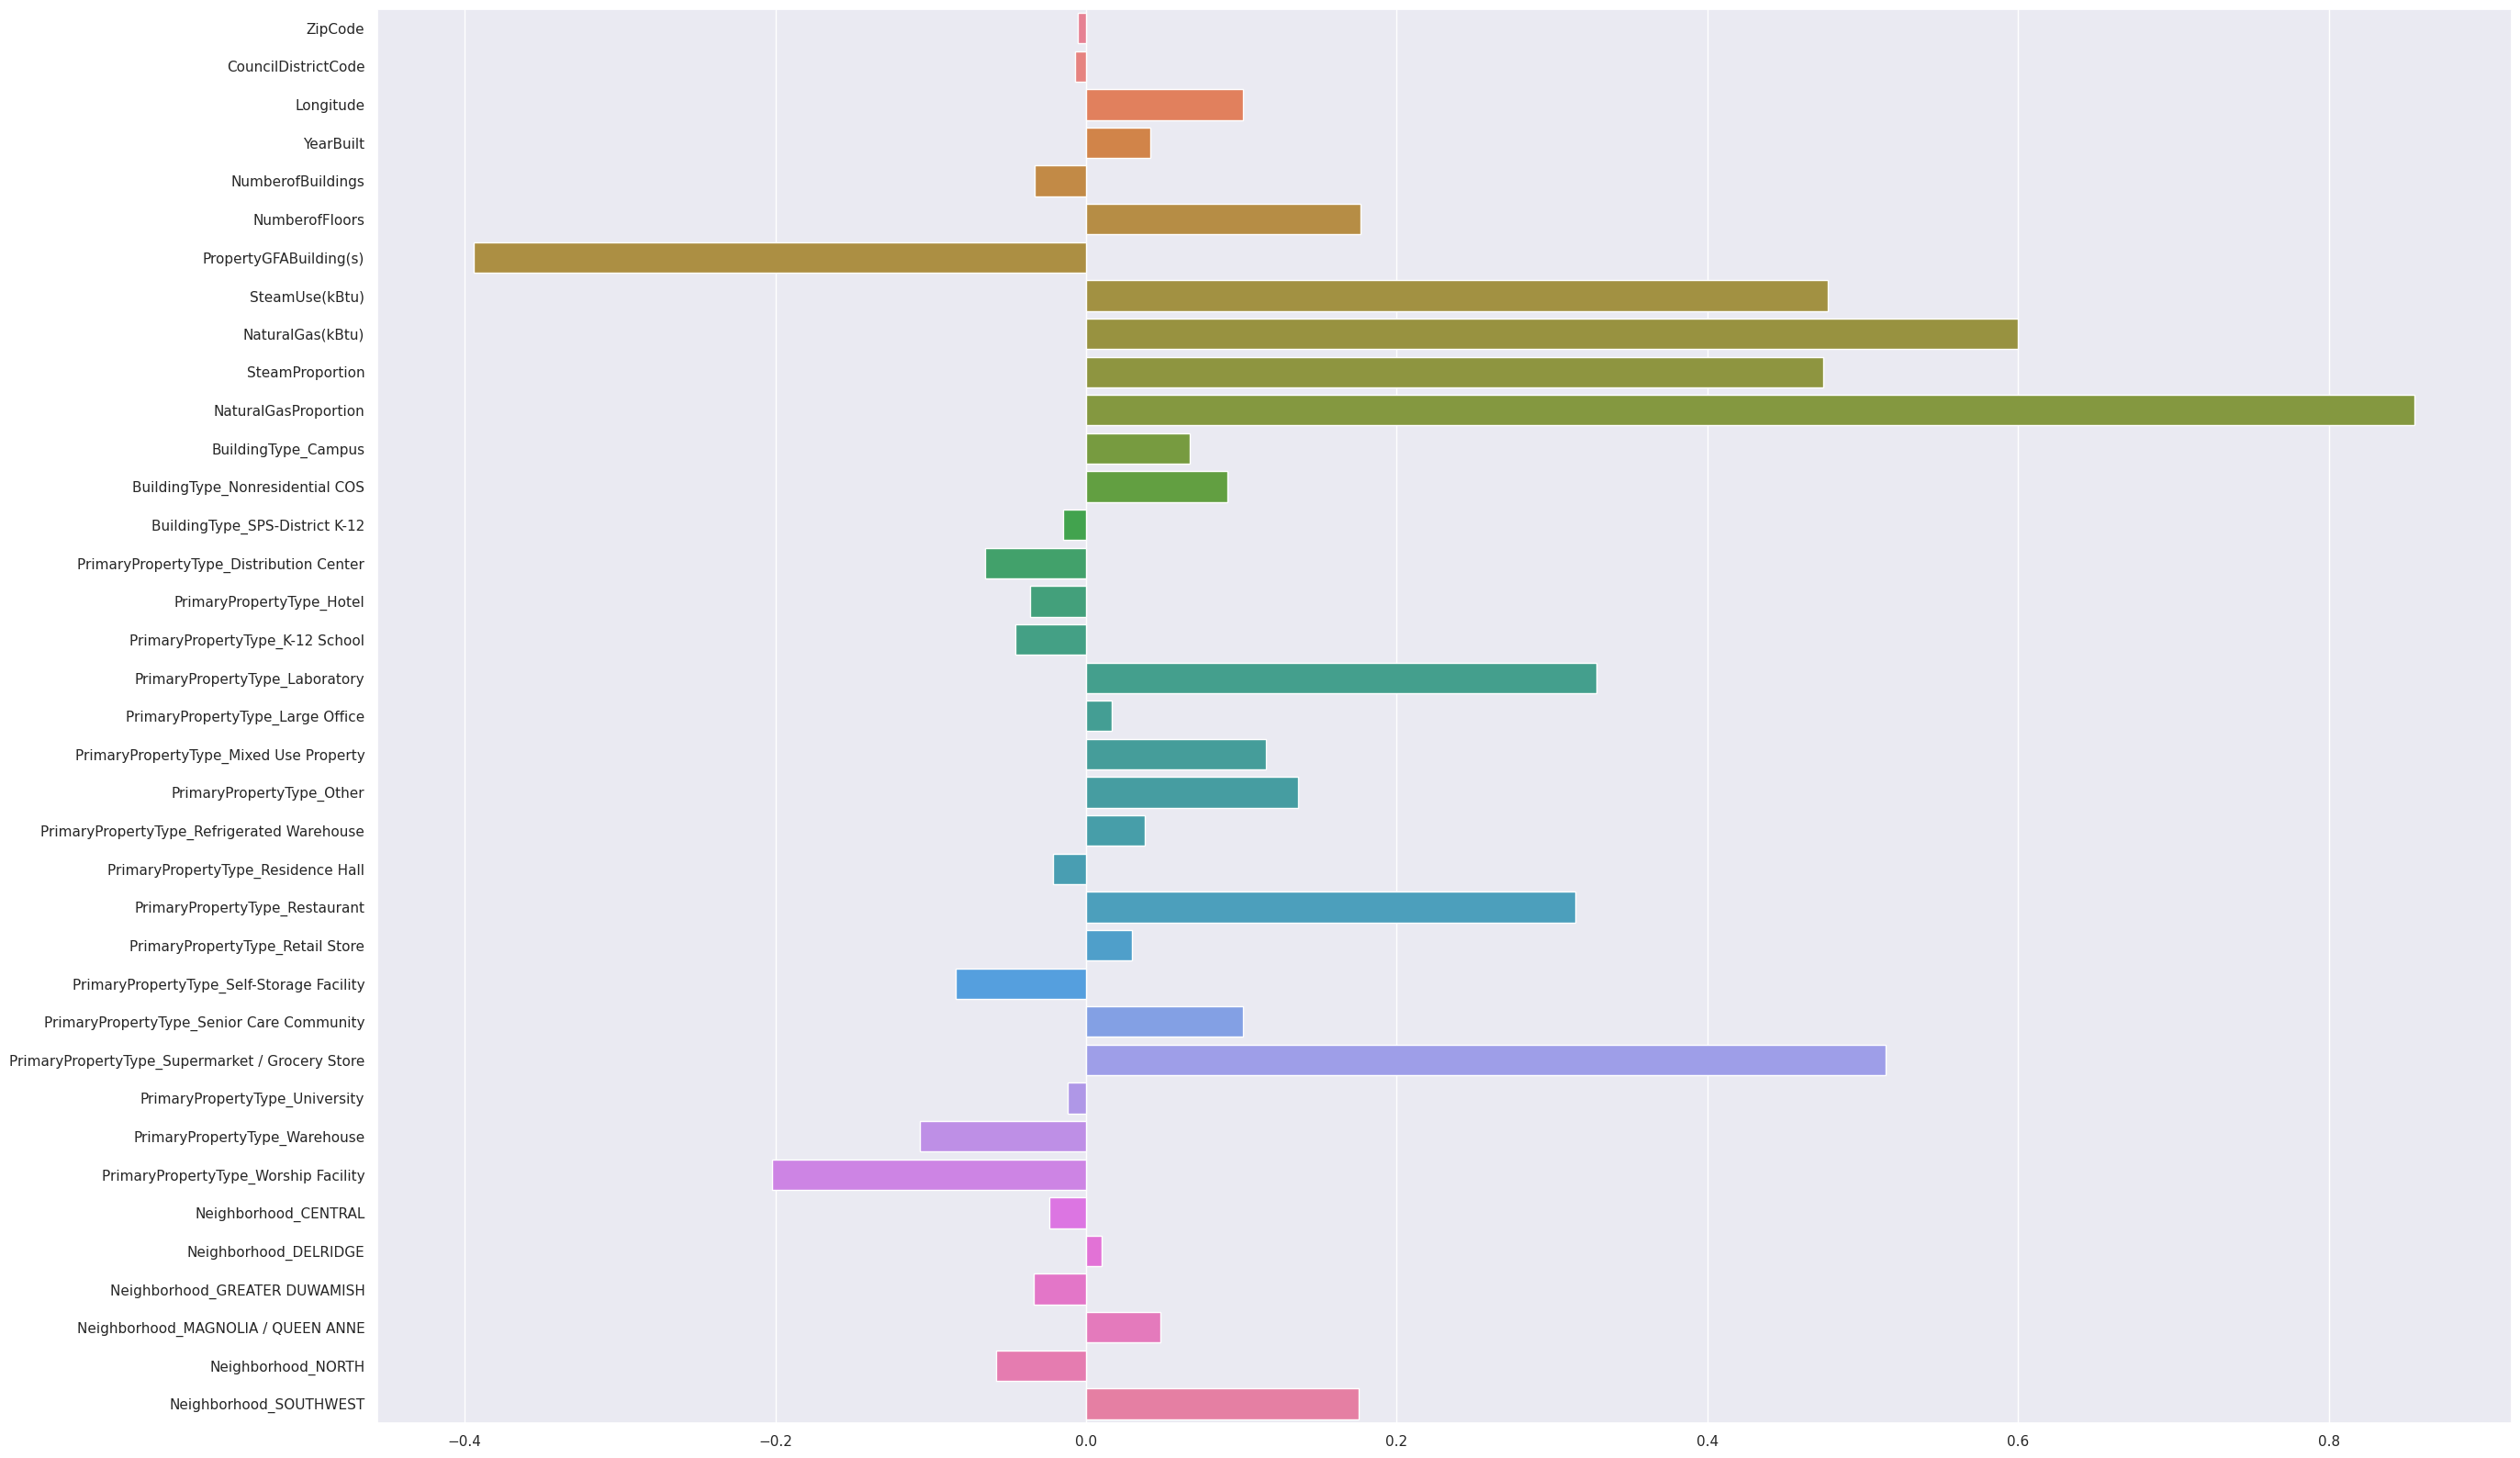

Evaluation started for model:Ridge


/home/xavier/Desktop/formation/project_3/.venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.64388e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/xavier/Desktop/formation/project_3/.venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.54416e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/xavier/Desktop/formation/project_3/.venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.04546e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/xavier/Desktop/formation/project_3/.venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.08767e-17): result may not be accurate.
  return 

Best mean squared score:-1.404564472322939 with params:{'model': Ridge(), 'model__alpha': 1.0, 'numeric-data-transformer__add_energy_proportions_data': True, 'numeric-data-transformer__data_transformation_mode': 'normalization', 'numeric-data-transformer__use_log_values': False, 'string-data-transformer__consider_string_values': True, 'string-data-transformer__encoding_mode': 'OneHotEncoding'}



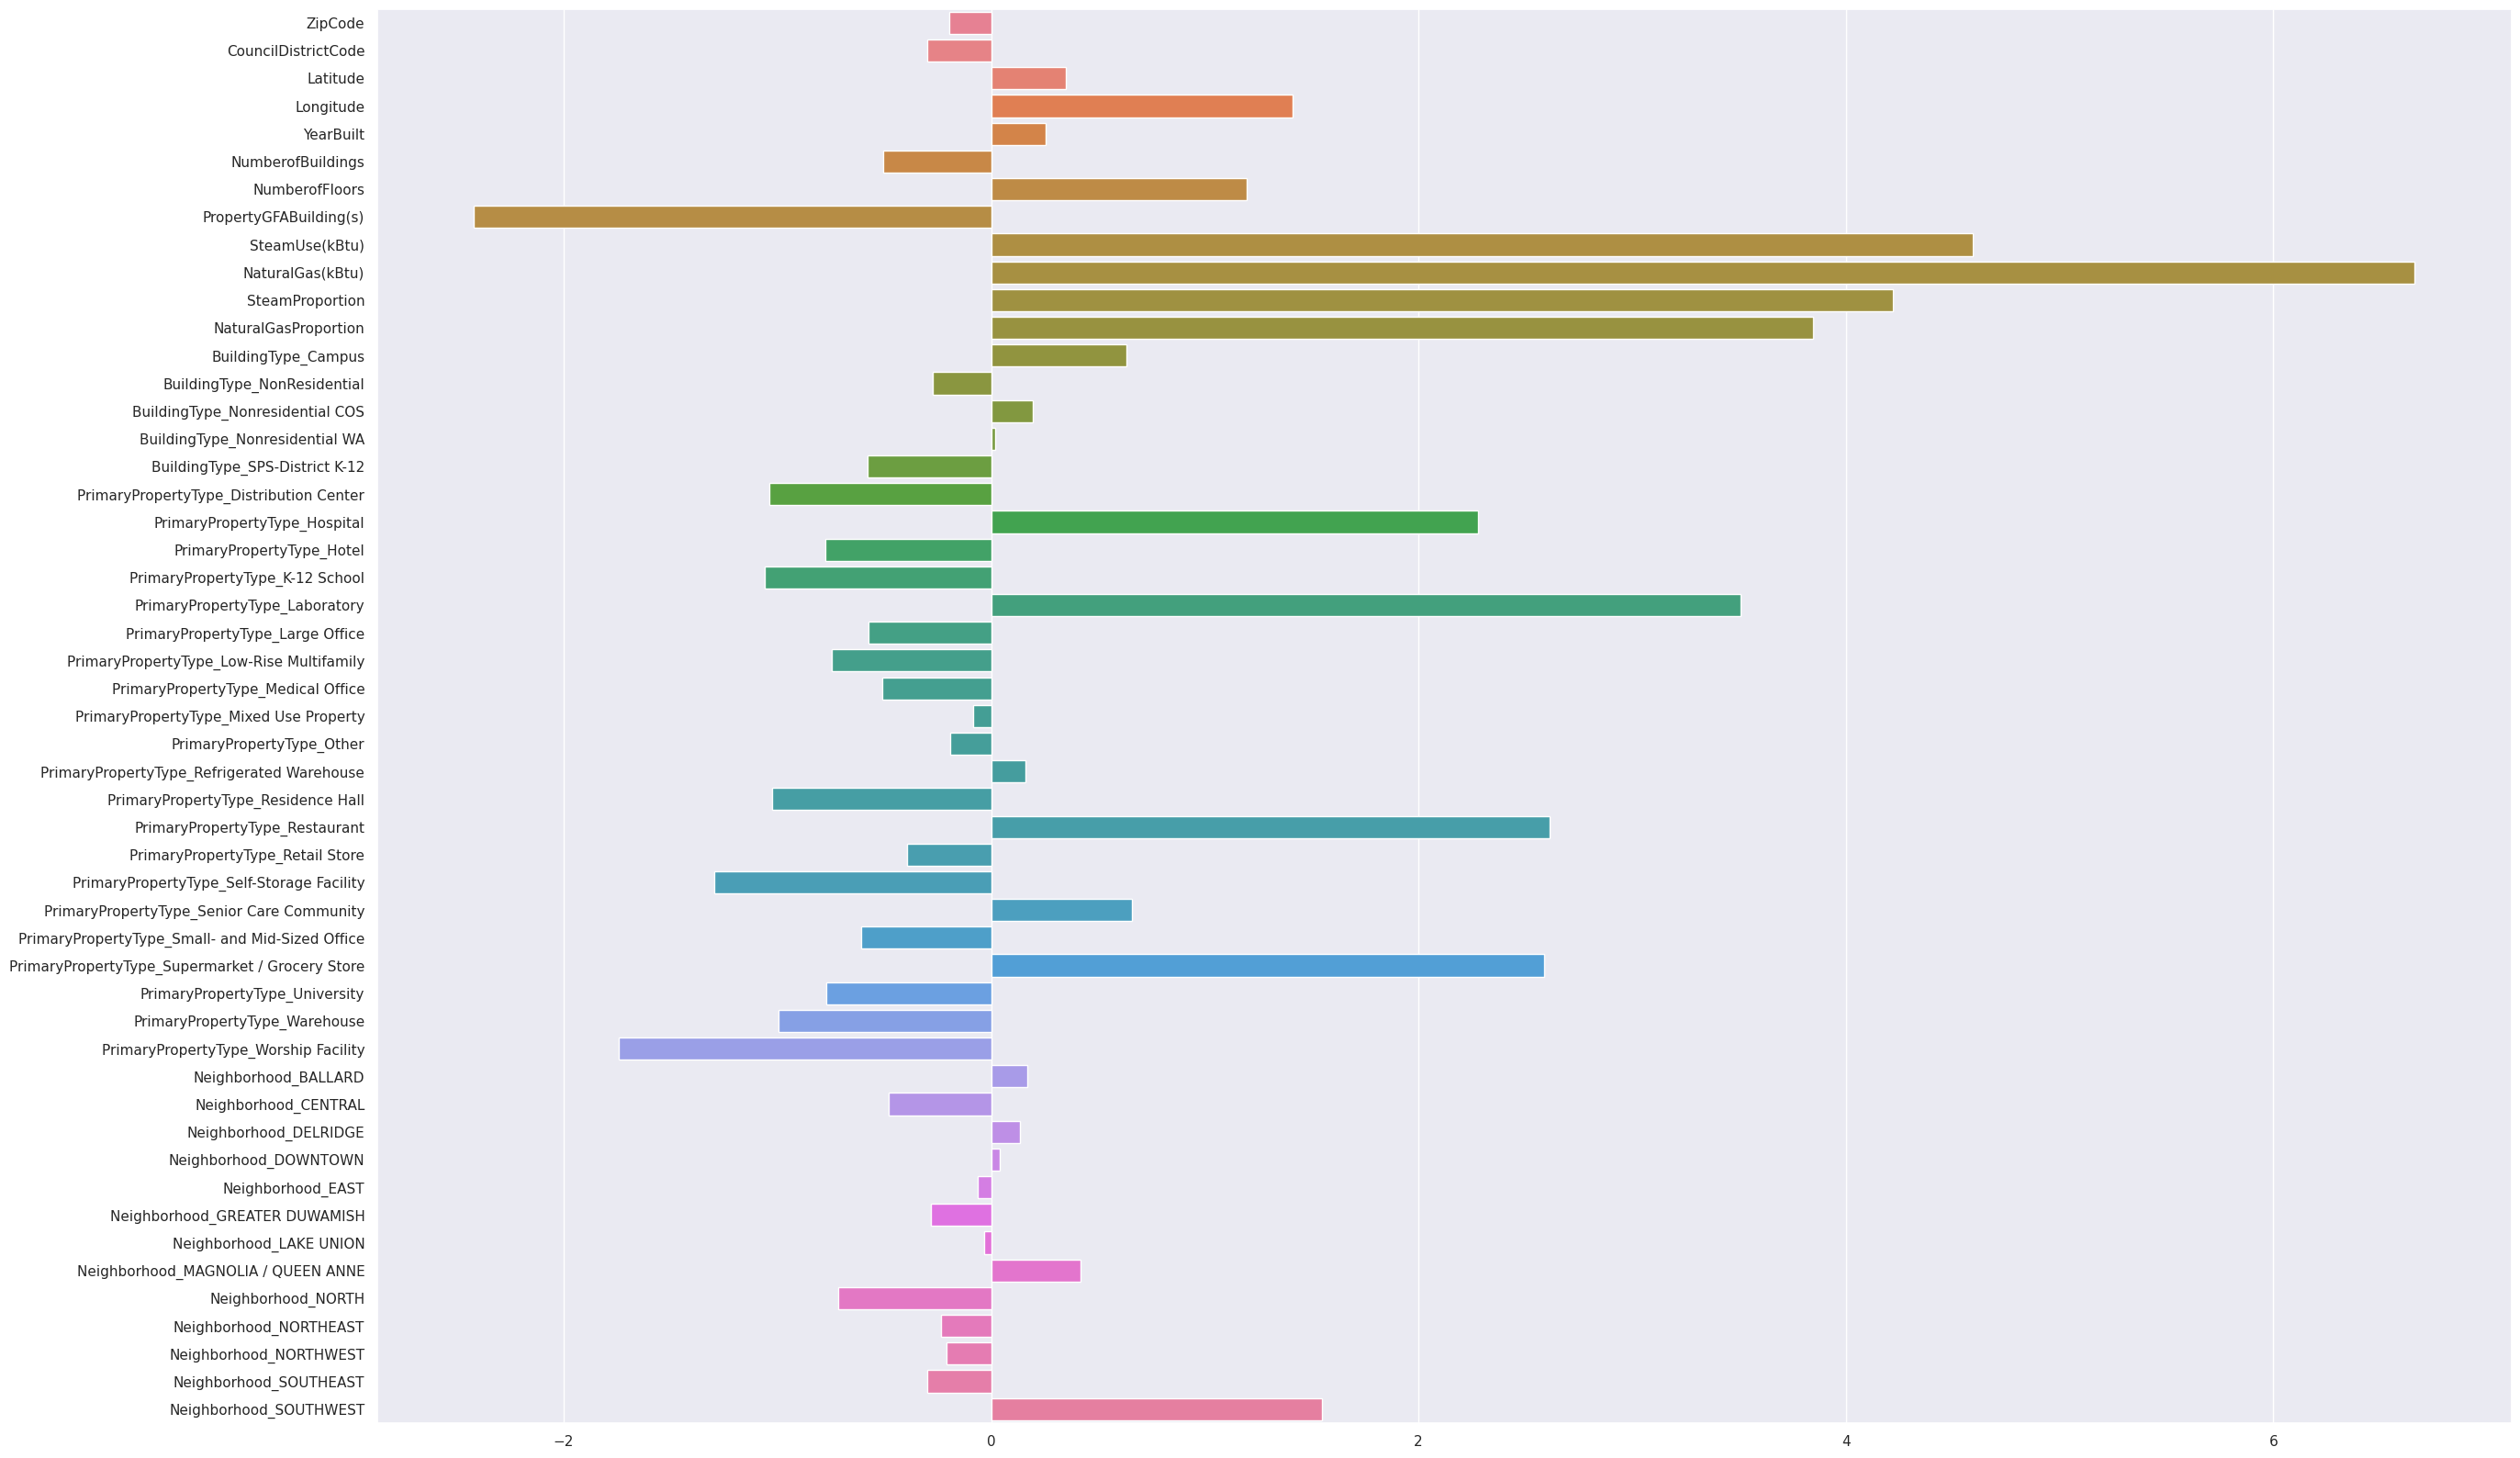

Evaluation started for model:ElasticNet
Best mean squared score:-1.5155183341197123 with params:{'model': ElasticNet(), 'model__alpha': 0.01, 'model__l1_ratio': 0.2, 'numeric-data-transformer__add_energy_proportions_data': True, 'numeric-data-transformer__data_transformation_mode': 'normalization', 'numeric-data-transformer__use_log_values': False, 'string-data-transformer__consider_string_values': True, 'string-data-transformer__encoding_mode': 'OneHotEncoding'}



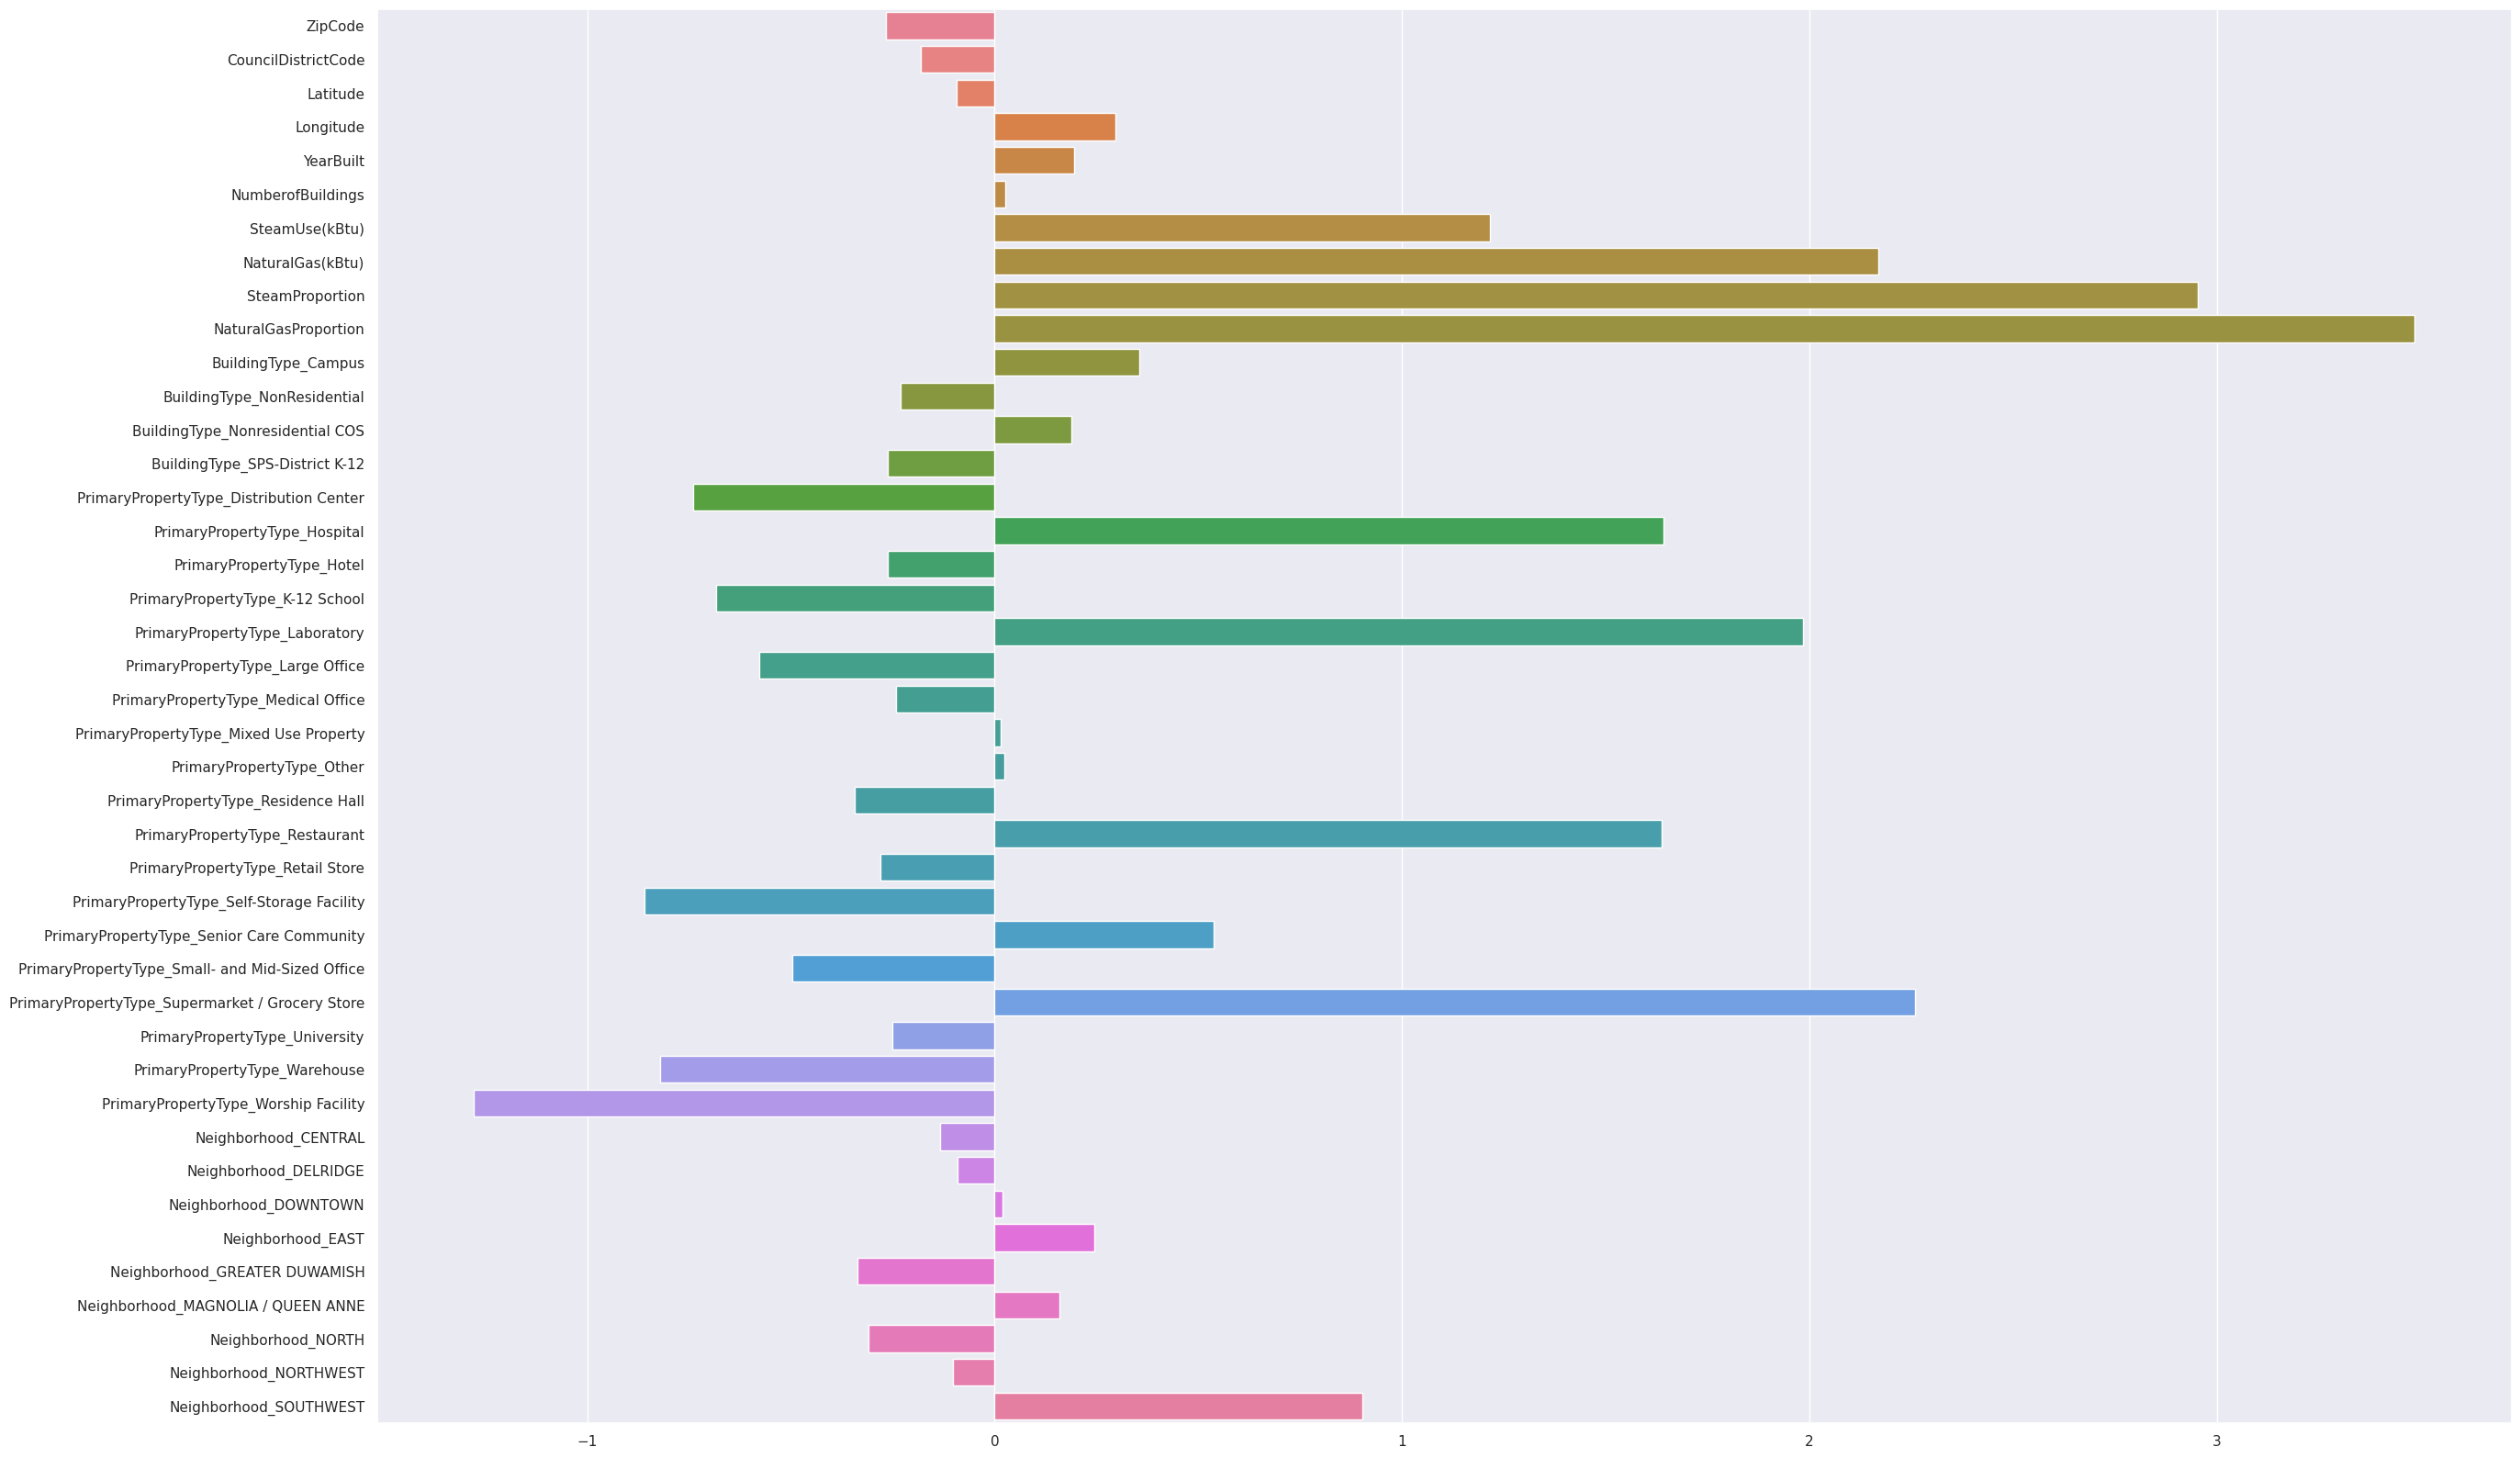

Evaluation started for model:SVR
Best mean squared score:-1.285458950955475 with params:{'model': SVR(cache_size=500), 'model__C': 1000, 'model__epsilon': 0.1, 'model__gamma': 0.001, 'numeric-data-transformer__add_energy_proportions_data': True, 'numeric-data-transformer__data_transformation_mode': 'standardization', 'numeric-data-transformer__use_log_values': False, 'string-data-transformer__consider_string_values': True, 'string-data-transformer__encoding_mode': 'OneHotEncoding'}

No feature importance could be determined for the current model

Evaluation started for model:RandomForestRegressor
Best mean squared score:-0.8340331450908142 with params:{'model': RandomForestRegressor(n_estimators=300), 'model__max_depth': 7, 'model__max_features': 9, 'numeric-data-transformer__add_energy_proportions_data': True, 'numeric-data-transformer__data_transformation_mode': 'standardization', 'numeric-data-transformer__use_log_values': False, 'string-data-transformer__consider_string_values': Tr

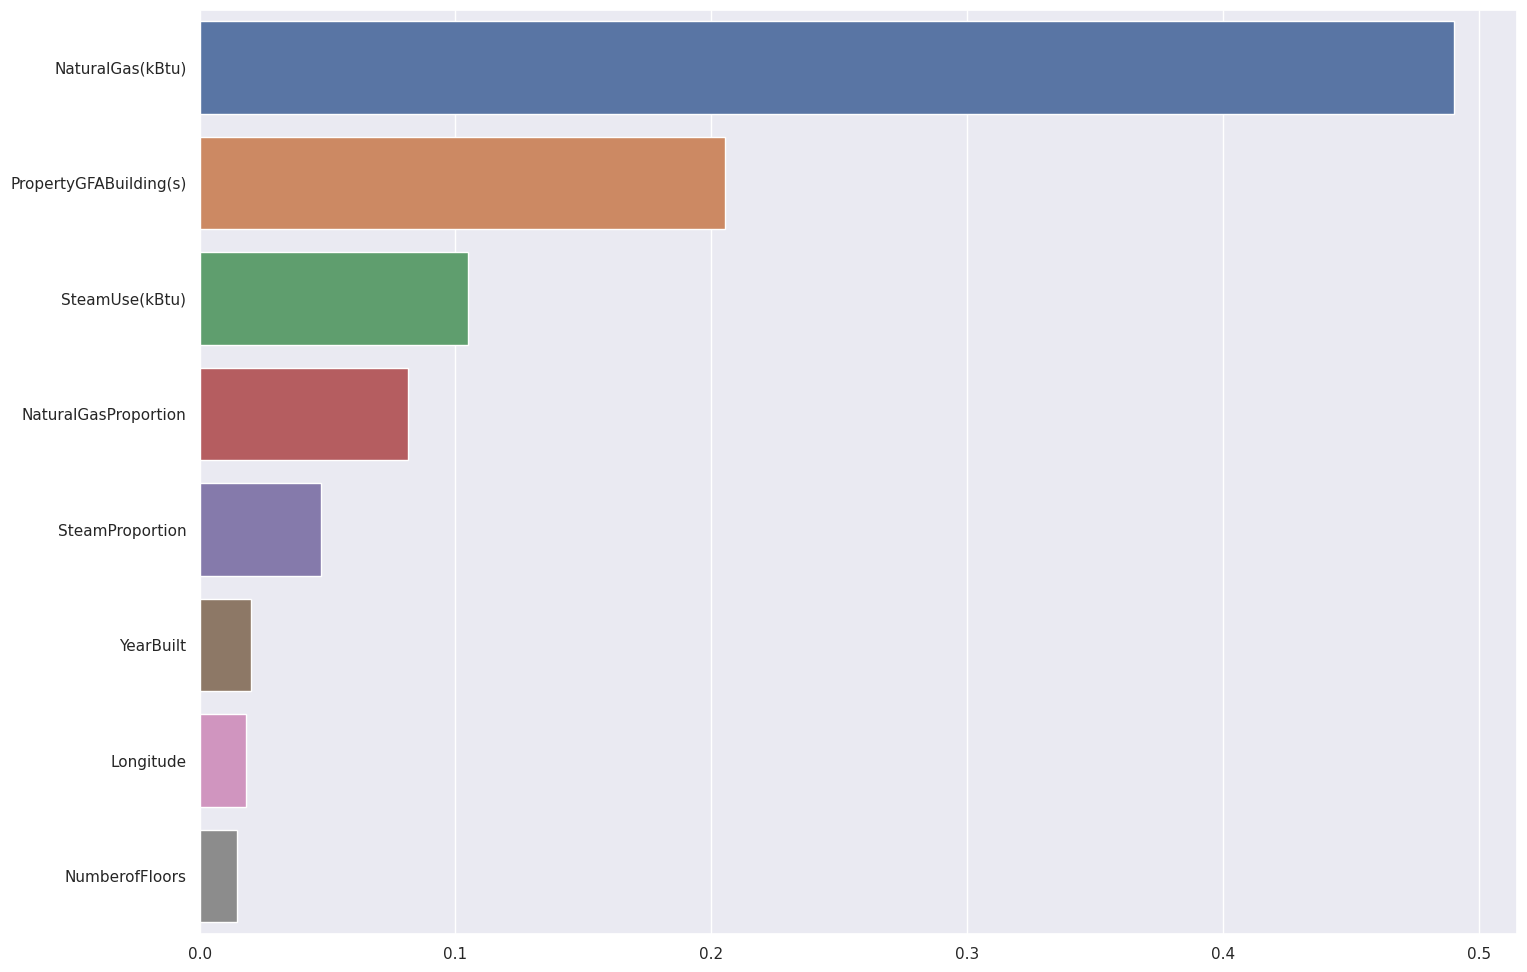

Evaluation started for model:GradientBoostingRegressor
Best mean squared score:-0.7273812261042721 with params:{'model': GradientBoostingRegressor(n_estimators=300), 'model__max_depth': 3, 'model__max_features': 7, 'numeric-data-transformer__add_energy_proportions_data': True, 'numeric-data-transformer__data_transformation_mode': 'None', 'numeric-data-transformer__use_log_values': True, 'string-data-transformer__consider_string_values': False, 'string-data-transformer__encoding_mode': 'TargetEncoding'}



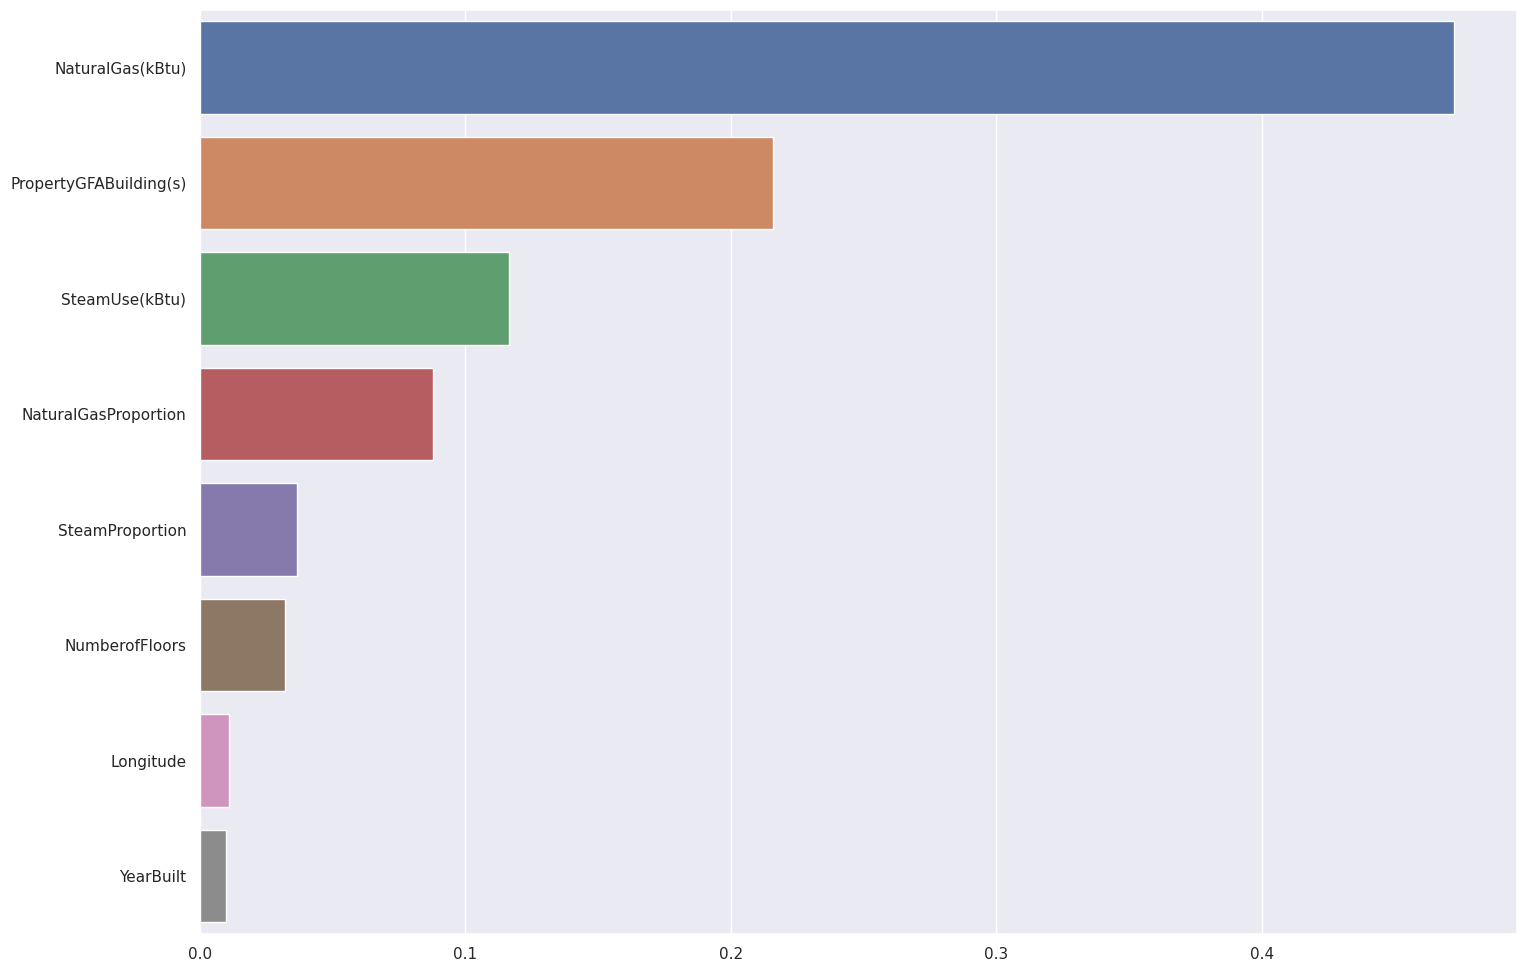

Evaluation started for model:XGBRegressor
Best mean squared score:-0.741083328381238 with params:{'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'model__max_depth': 2, 'numeric-data-transformer__add_energy_proportions_data': False, 'numeric-data-transformer__data_transformation_mode': 'norm

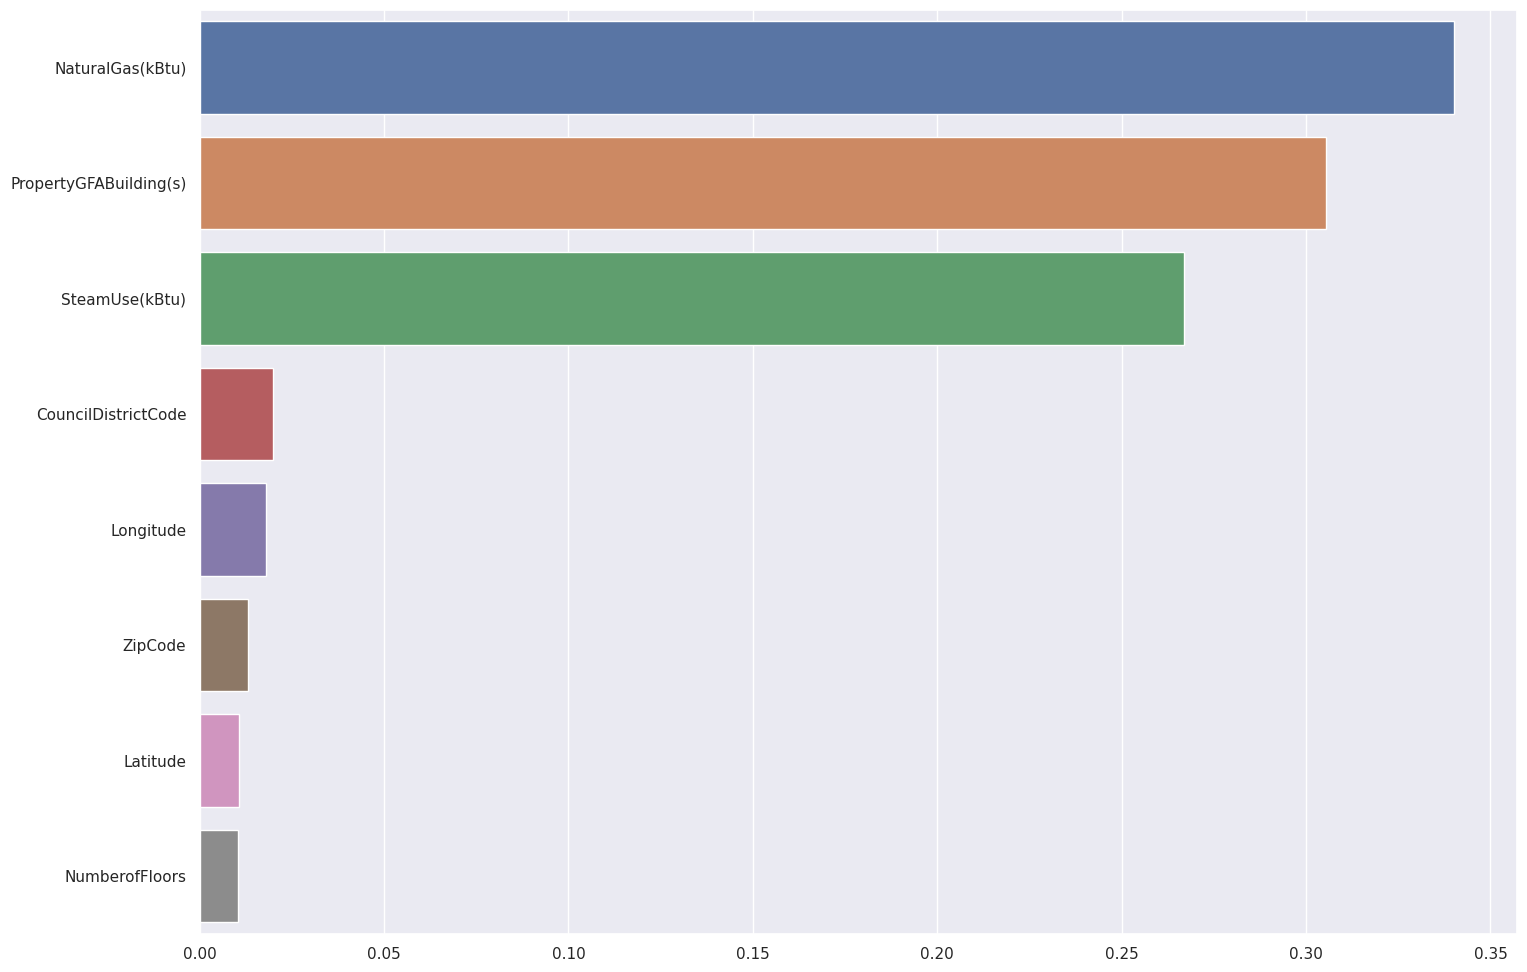

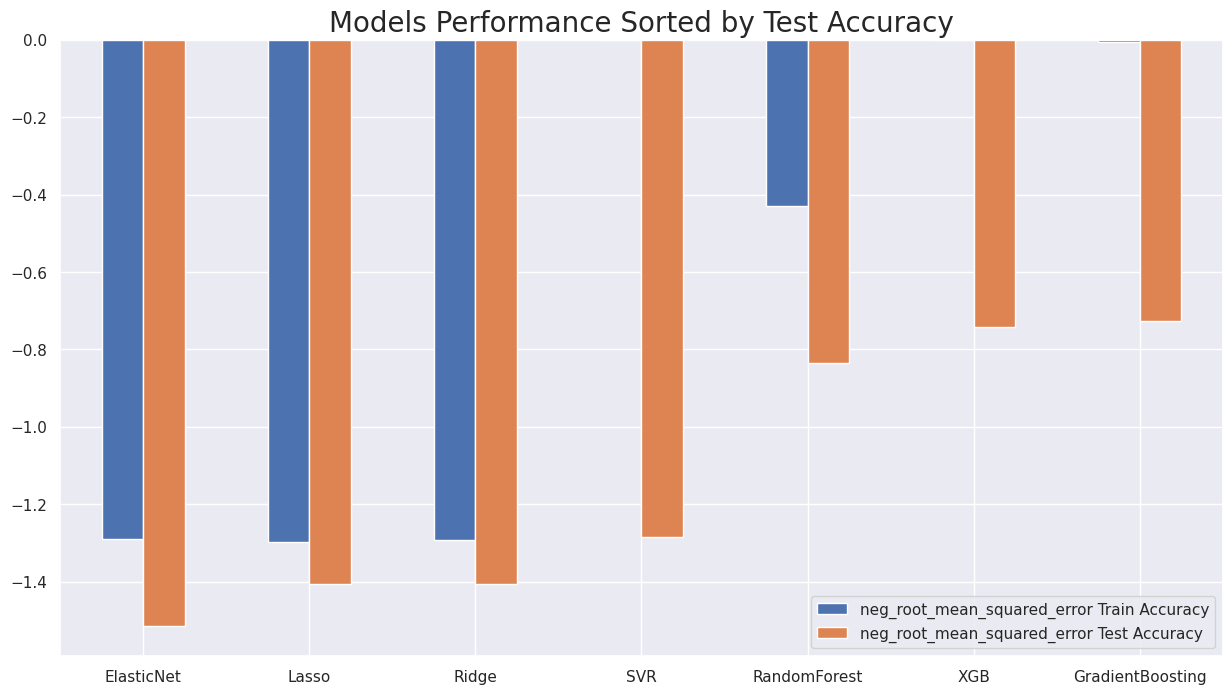

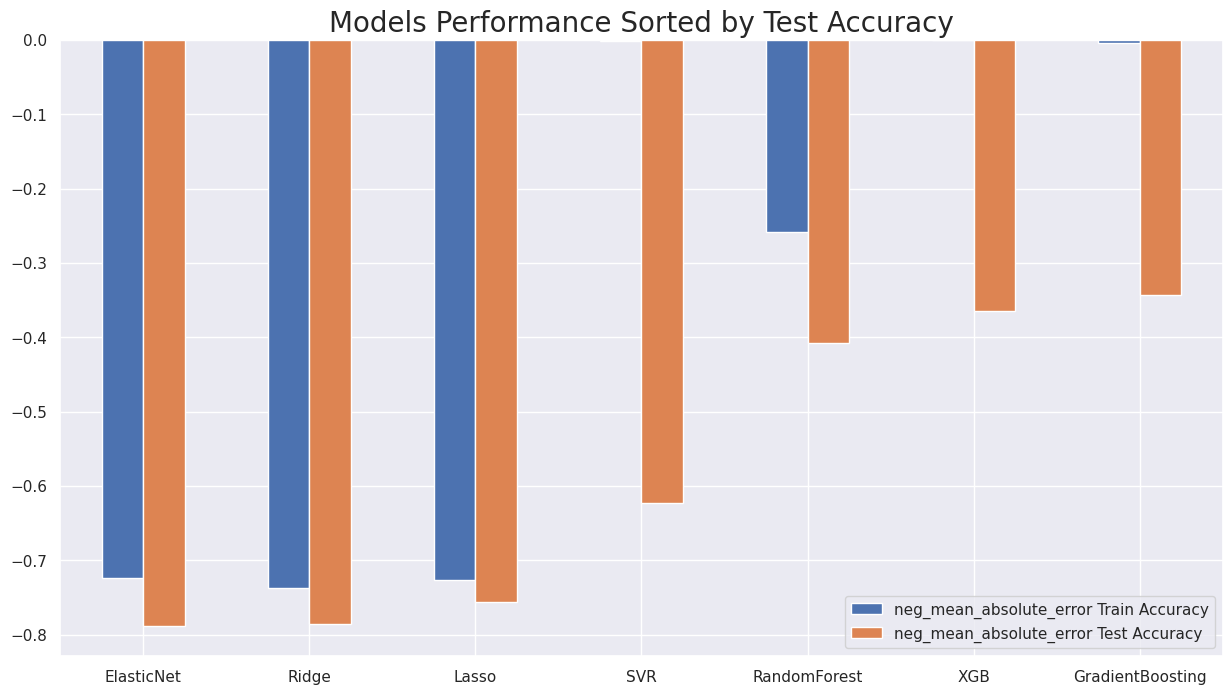

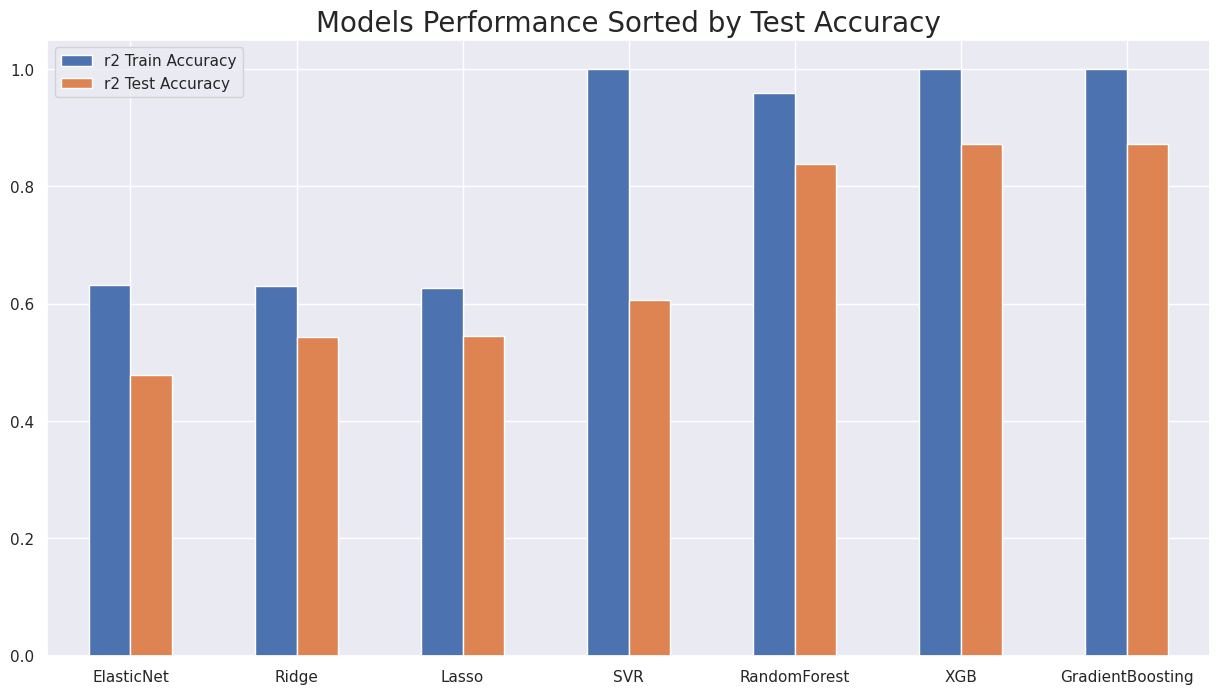

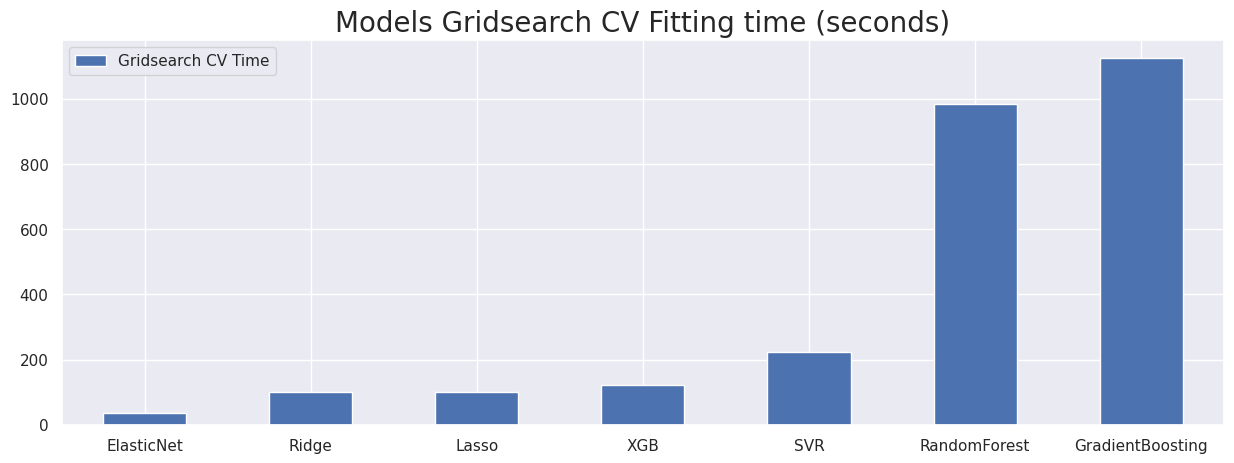


Displaying now Lime and Shap results for the best model

Intercept 0.6008693377434238
Prediction_local [4.19570613]
Right: -0.10547440034074053


/home/xavier/Desktop/formation/project_3/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


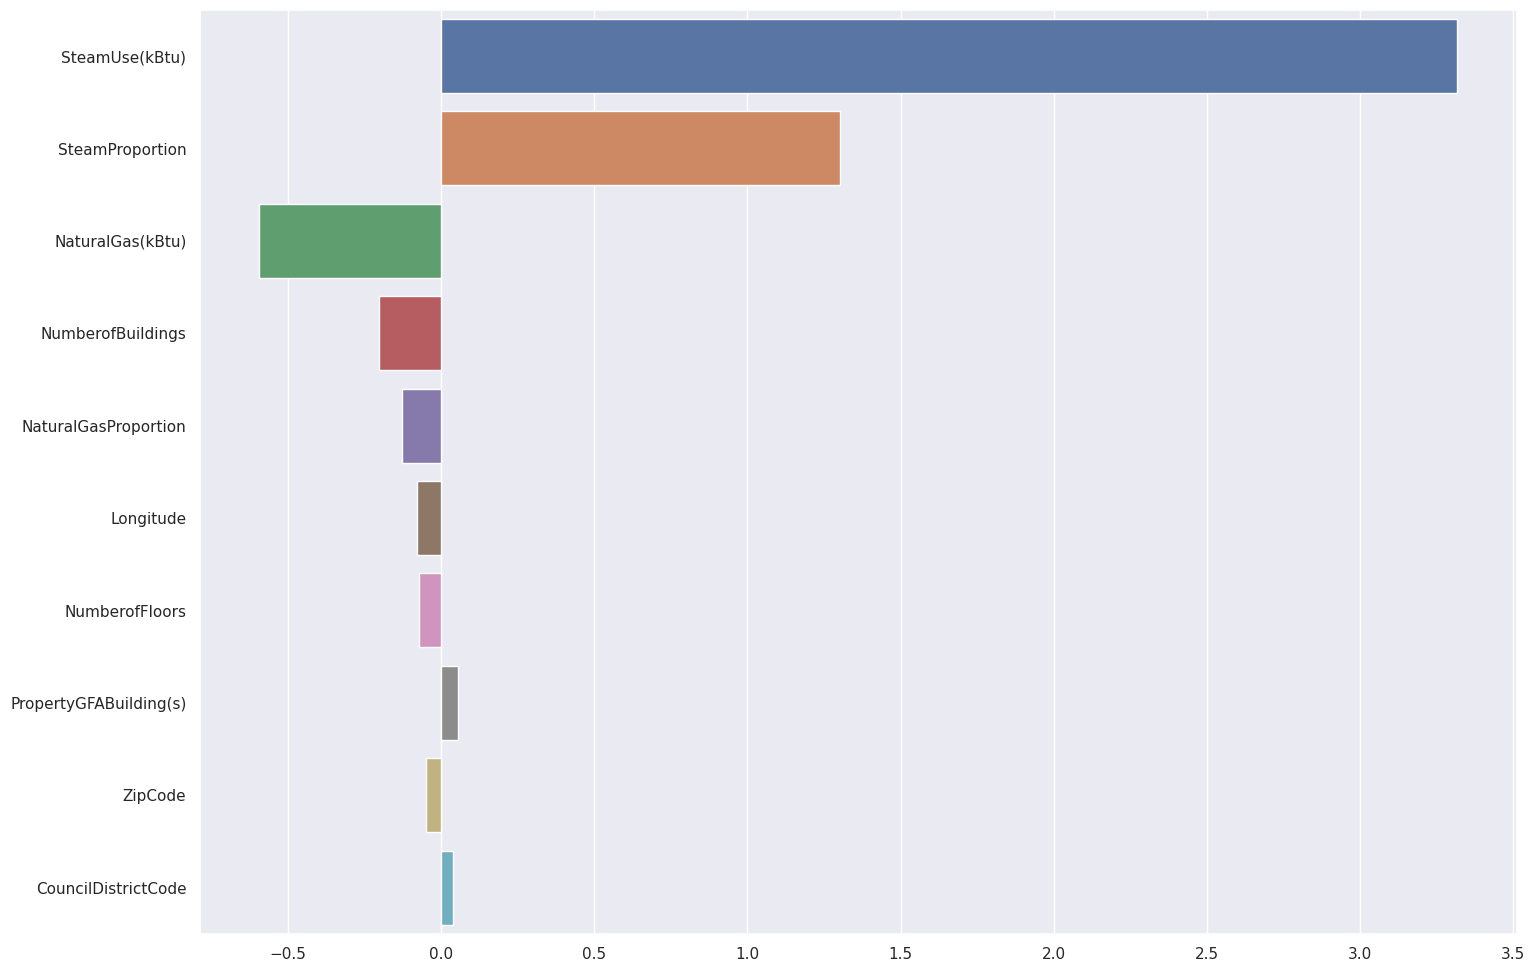

Intercept 4.969343038907591
Prediction_local [0.18689579]
Right: 0.09668798260378755


/home/xavier/Desktop/formation/project_3/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


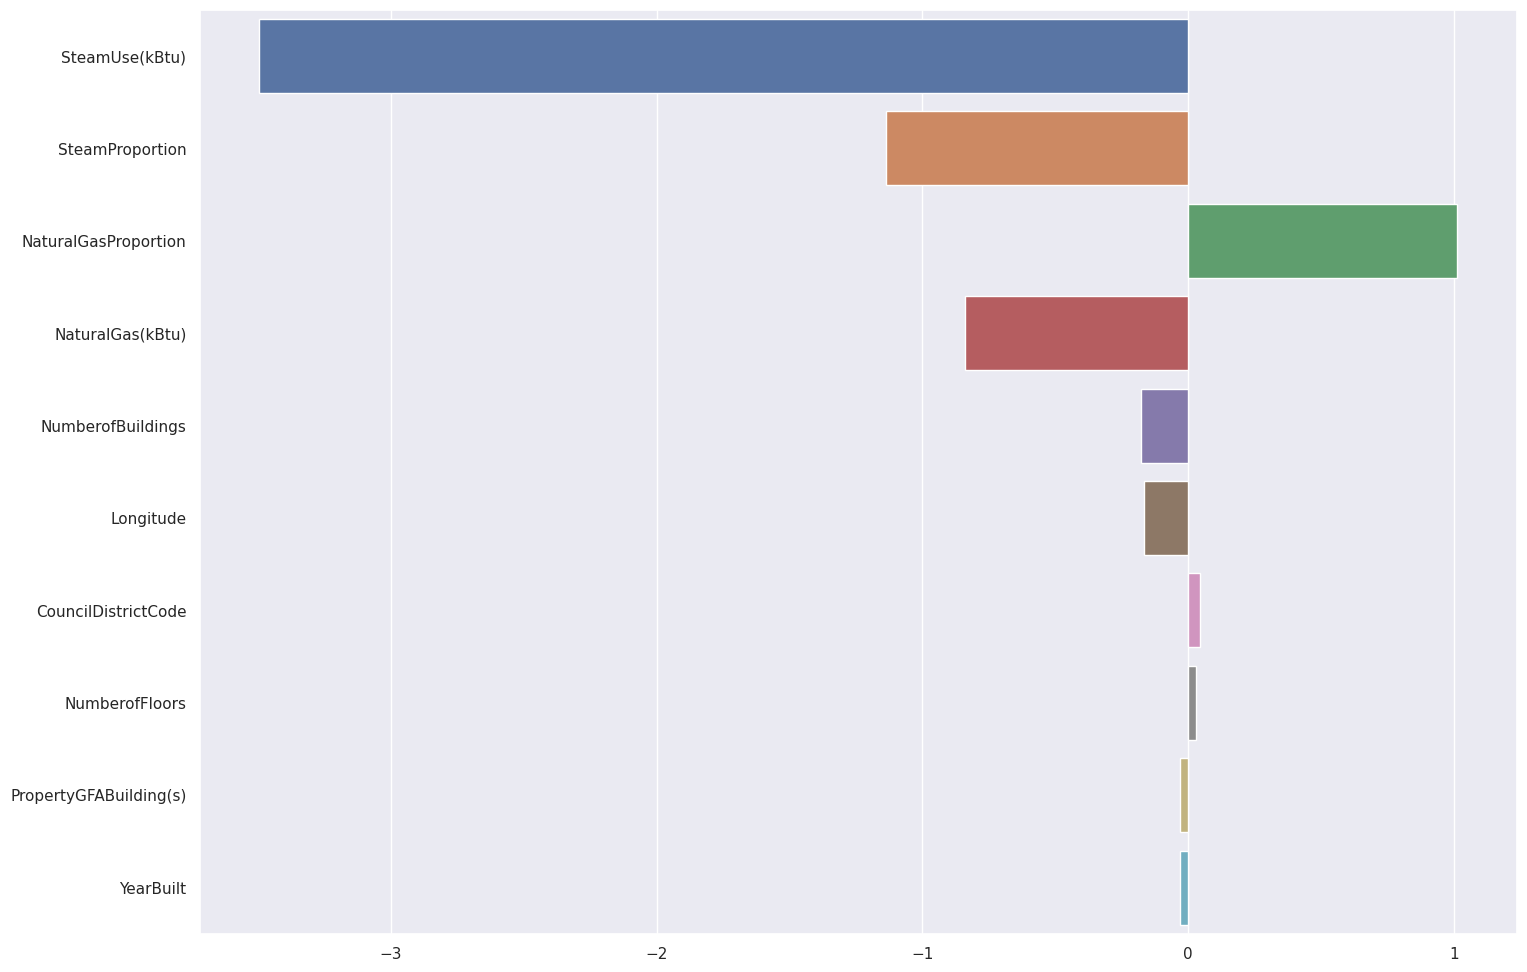

Intercept 4.681726862557986
Prediction_local [0.96012158]
Right: 0.07013104030883367


/home/xavier/Desktop/formation/project_3/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


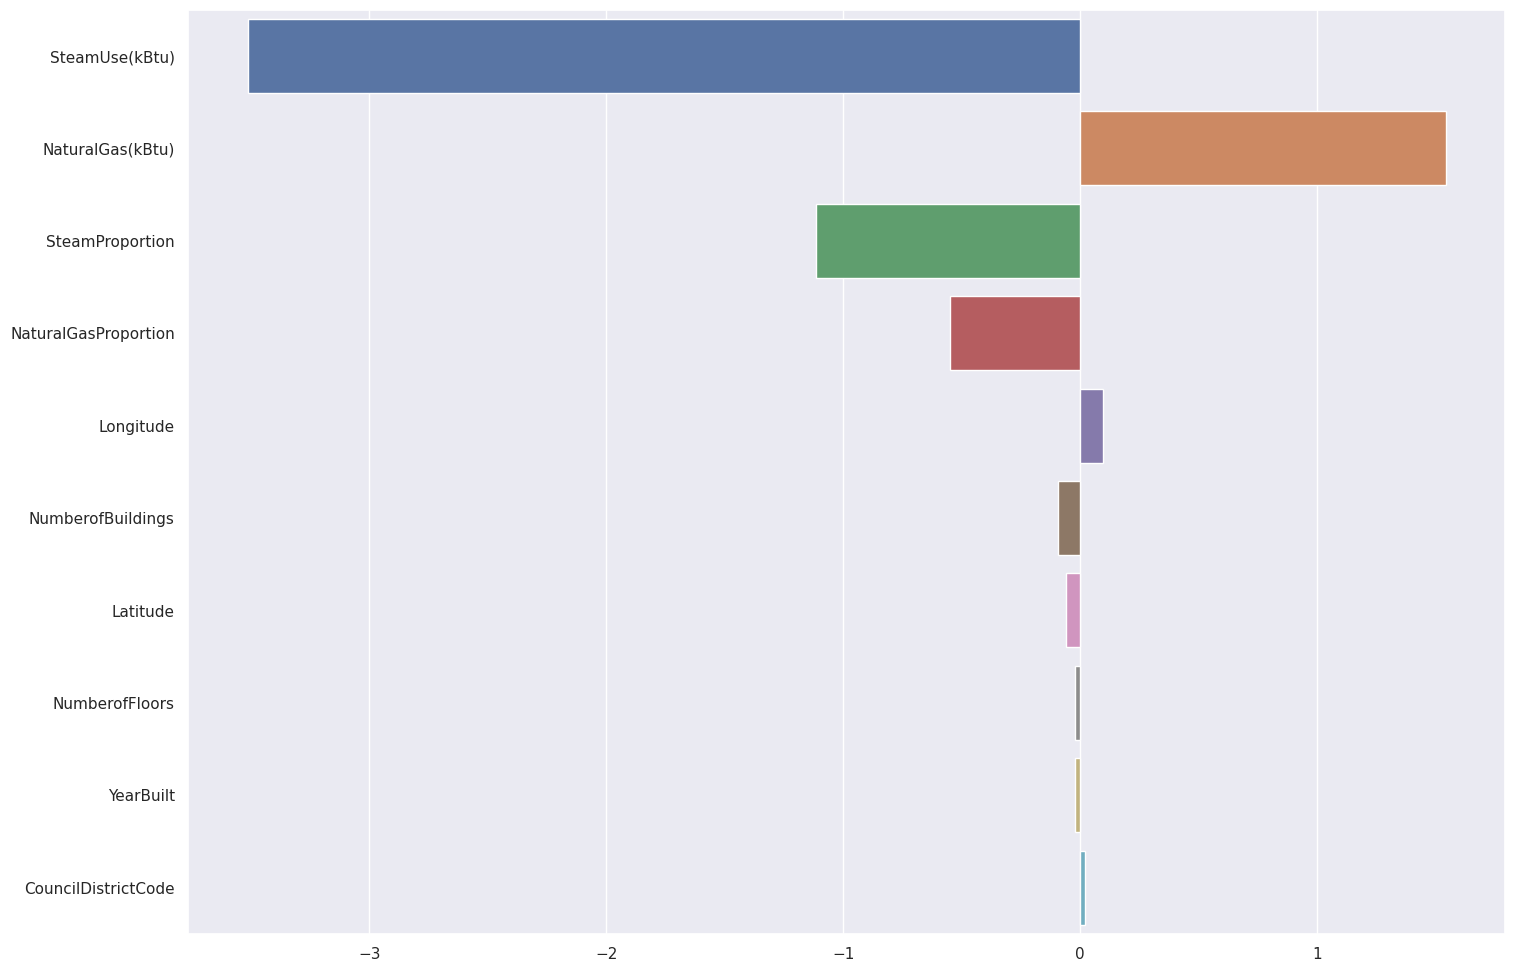

Intercept 5.317242820906974
Prediction_local [0.13424737]
Right: 0.14771312082857022


/home/xavier/Desktop/formation/project_3/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


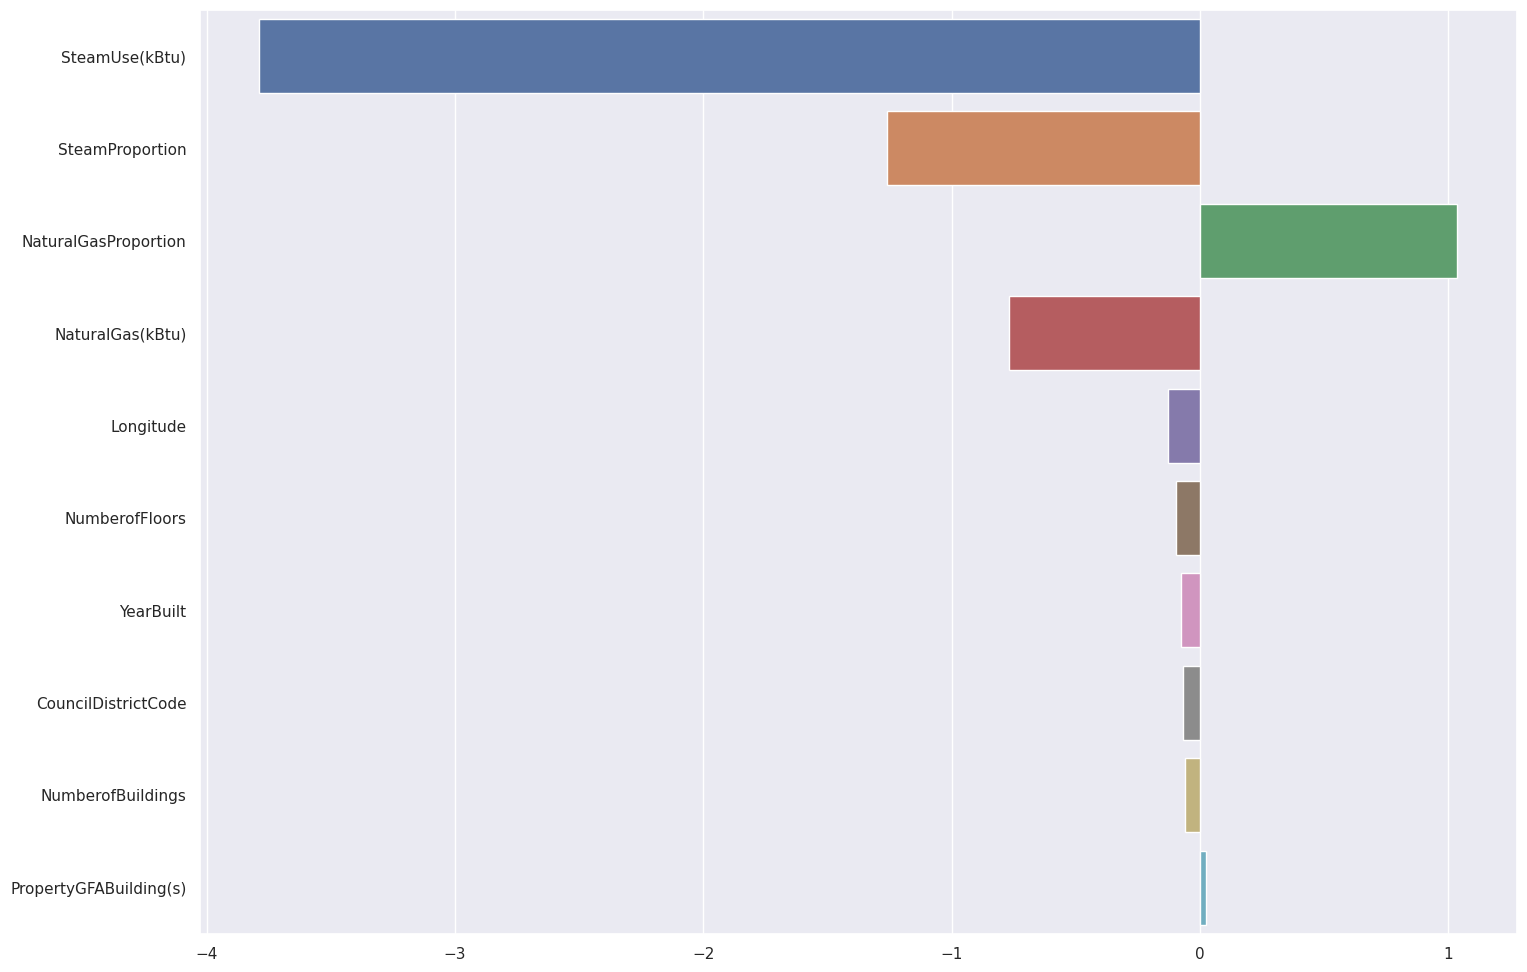

/home/xavier/Desktop/formation/project_3/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Intercept 5.048449028409598
Prediction_local [0.17858809]
Right: 0.2620785444572271


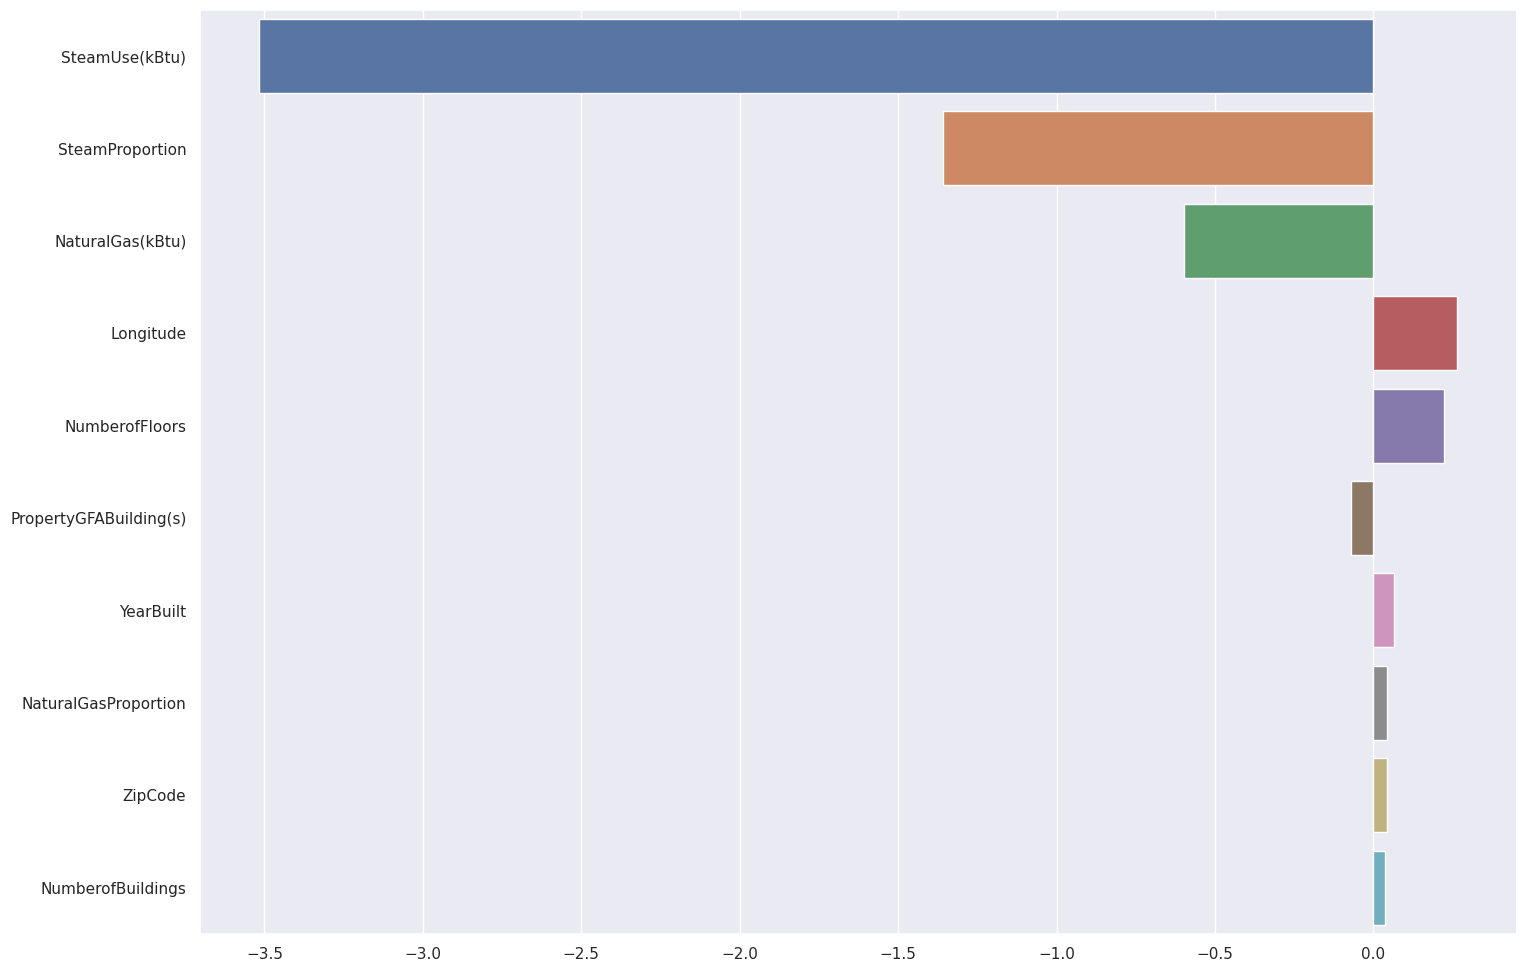

  0%|          | 0/291 [00:00<?, ?it/s]

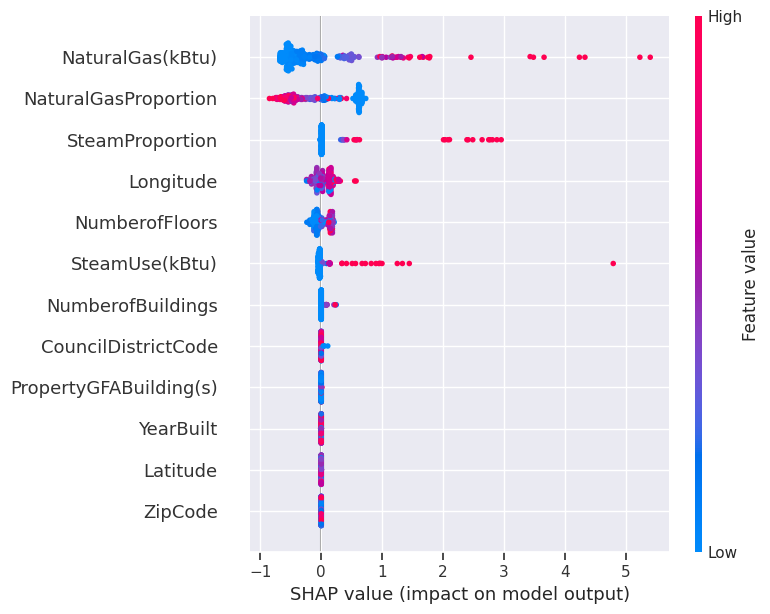


Now using the best determined model to evaluate the impact of the Energy Star Score.

14 duplicates were removed based on the PropertyName.

Removing 1358 non-residential buildings
Best mean squared score:-0.9638644658622105 without energy star score.
Best mean squared score:-0.9706028443912127 with energy star score.


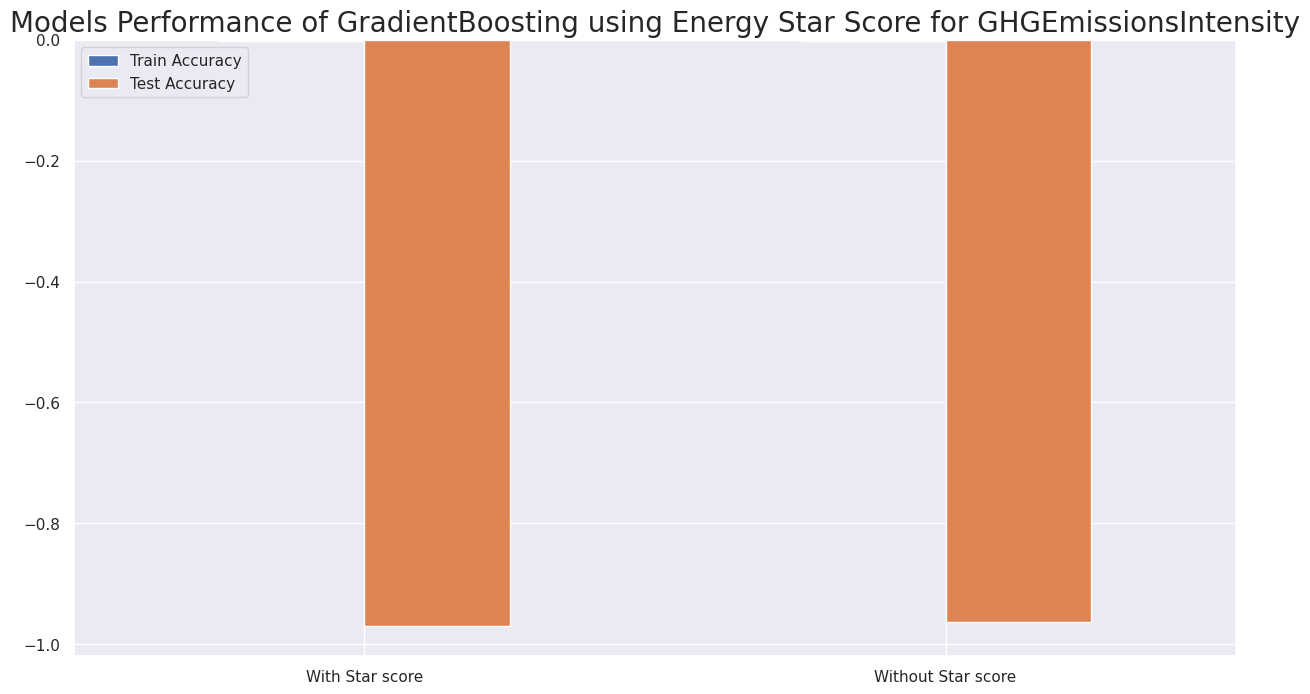

In [24]:
print("Starting script.\n")

dataframe: DataFrame = load_and_filter_data()
print("The dataset has been loaded and filtered. Let's clean the data.\n")

print(f"Dataset size before cleaning and preparation:{len(dataframe)}")
dataframe = prepare_data(dataframe)
print(f"Dataset size after cleaning and preparation:{len(dataframe)}\n")

set_without_target_column_values = dataframe.drop(TARGET_COLUMN, axis=1)
target_column_values = dataframe[TARGET_COLUMN]

x_train, x_test, y_train, y_test = train_test_split(set_without_target_column_values, target_column_values,
                                                    test_size=0.2, random_state=42)
print(f"training set size:{len(x_train)}, test set size:{len(x_test)}\n")

results = []
scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']
for model_parameters in get_models_and_their_hyperparameters():
    pipeline = Pipeline(steps=[
        ("string-data-transformer", StringDataTransformer()),
        ("numeric-data-transformer", NumericDataTransformer()),
        ("model", LinearRegression())
    ])

    model_name = model_parameters['model'][0].__class__.__name__
    print(f"Evaluation started for model:{model_name}")

    grid_search_cv = GridSearchCV(pipeline, model_parameters, cv=KFold(10, shuffle=True),
                                  scoring=scoring, n_jobs=-1, refit='neg_root_mean_squared_error',
                                  return_train_score=True)
    start_time = time.time()
    grid_search_cv.fit(x_train, y_train)
    fit_time = time.time() - start_time

    best_parameters = grid_search_cv.best_params_
    print(f"Best mean squared score:{grid_search_cv.best_score_} with params:{best_parameters}\n")

    transformed_x_train, transformed_x_test = transform_sets_to_current_best_parameters(x_train, x_test, y_train,
                                                                                        y_test, best_parameters)
    model = grid_search_cv.best_estimator_._final_estimator
    create_feature_importance_plots(model, transformed_x_train.keys(), model_name)

    result = {
        "best_parameters": best_parameters,
        "model_parameters": model_parameters,
        "model": model,
        "model_name": model_name.replace("Regressor", ""),
        "fit_time": fit_time
    }

    add_scores_to_result(result, grid_search_cv.cv_results_, scoring)
    results.append(result)

create_comparison_plots(results, scoring)

print("\nDisplaying now Lime and Shap results for the best model\n")
best_result = sorted(results, key=lambda x: x['neg_root_mean_squared_error_test_score'], reverse=True)[0]

transformed_x_train, transformed_x_test = (
    transform_sets_to_current_best_parameters(x_train, x_test, y_train, y_test, best_result['best_parameters']))

explain_results_using_shap(best_result['model'], best_result['model_name'], transformed_x_test)
explain_results_using_lime(transformed_x_train, transformed_x_test, best_result['model_name'], best_result['model'],
                           transformed_x_train.columns)

evaluate_impact_of_energy_star_score(best_result['model_parameters'], best_result['model_name'])